# Project name: 
    The Functional Neuroanatomy of the Human Subthalamic Nucleus
    
    Initial code by Gilles de Hollander; 
    Edited by Steven Miletic and Max Keuken

# Goal of the project: 
    To investigate the internal organisation of the human subthalamic nucleus using histology. The non-demented control tissue has been originally analyzed by Gilles de Hollander. 

# Layout of the Notebook
### 1) Combine and store the data:
    1) import histo data into a HDF5 file that contains the histo data and the STN masks in the folder:
       /home/mkeuken1/data/post_mortem/new_data_format/

### 2) Plot the data:
    2) load in the HDF5 data files using the base.py script. The base.py script loads in the data, sets the resolution but also smooths the data with a number of smoothing kernels (0.15, 0.3, 0.6, 1.2, and 2.4 mm fwhm). The reason why we have such a large number of smoothing kernels is because we ran a simulation to generate a hypothesis figure. Here we noted that if the smoothing kernel was too small the histograms were very noisy, if the smoothing kernel was very large you cannot find small transition zones. So there needed to be a bit of a balance. We decided to run the entire analysis for the 5 different smoothing kernels. The final choice of fwhm to report in the main manuscript was based on consistency accross tissue blocks, the other kernels were placed in the supplements.  

### 3) Define main in-plane axes using a PCA on the masks of the STN
    The first axis is defined as the slice direction; the in-plane main axes are defined using a PCA.
    The STN is subsequently split into 12x12x12 voxels (each axes is cut into 12 equal sectors). Each voxel contains the main number of counts.
    NB: Since the voxels are mean counts across many original data points, we use the unsmoothed data to create voxels.

### 4) GLM analysis
    Analyze whether the stain intensity depends on its location in space along the axes defined in pt 3. This is done using a set of GLMs with Poisson-distributed errors, with or without an additional overdispersion parameter (i.e., using the negative binomial distribution)
    Models are fitted for each specimen & stain separately using PyMC3.

### 1) Combine and store the data
#### Importing the histological data as well as the masks of the STN and save them into a HDF5 file.
 

In [2]:
############
# What is the exact dataset that we are working with?
############

# The stain data of the following tissue blocks: 13095, 14037, 14051, 14069, 15033, 15035, 15055 
# 
# The specific data files are the processed files that will also be shared via DANS/Figshare. 
# The DANS/Figshare has the following folder structure:
#   Subject ID/
#              stain/
#                    unique stain/
#                                 orig/ (not relevant for this project, the multipage tiff as from the microscope)
#                                 proc/ (these are the files we will use for this project)
#              blockface/               (not relevant for this project)
#              MRI/                     (not relevant for this project)
#
# The stain data in the proc/ folder is aligned to the Blockface space
#
# All stain to blockface registration steps were visually inspected by Anneke Alkemade. If the registration failed, 
#   this stain and slice was excluded. See "exclusion_list.txt" for an overview. 
# 
# For this project the processed .png files (as indicated in the proc.DANS/Figshare folder) were renamed and
#   copied to the following folder:
#      data/STN_Histo/stacked_slides/
#
# How were the files renamed?
#    13095_vglut1_proc_1800_7561_2_blockface.png -> 13095_vglut1_1800_7561.png
#
#  and moved to their respective subjectID folder:
#    data/STN_Histo/stacked_slides/subjectID/
#
############
# Start code
############

# Importing a number of different tools
import re
import pandas
import glob
import h5py
import scipy as sp
from scipy import ndimage
import natsort
import numpy as np
import os

# Find the stains.png images per tissue blocks that have been registered to the blockface images
fns = glob.glob('/home/mkeuken1/data/post_mortem/stacked_slides/*/*')
reg = re.compile('.*/(?P<subject_id>[0-9]{5})_png/(?P<stain>[A-Za-z0-9]+)_(?P<slice>[0-9]+)_[0-9]+_(?P<id>[0-9]+)\.png')

df = pandas.DataFrame([reg.match(fn).groupdict() for fn in fns if reg.match(fn)])
df['subject_id'] = df['subject_id'].astype(int)
df['slice'] = df['slice'].astype(int)
df['fn'] = [fn for fn in fns if reg.match(fn)]
df['id'] = df['id'].astype(int)
# There were a number of stains where there were 2 images. The first image was before the tissue block
#  was moved forwards again during the cutting. The second image was once the cutting continued. We chose
#  to only keep the second image:
df = df.drop_duplicates(['subject_id', 'slice', 'stain'], keep='last')

# The naming conventions of the stains was lower case so rename to match to uppercase
def correct_stain(stain):
    if stain == 'calr':
        return 'CALR'
    
    if stain == 'fer':
        return 'FER'

    if stain == 'gabra3':
        return 'GABRA3'
    
    if stain == 'gad6567':
        return 'GAD6567'
    
    if stain == 'mbp':
        return 'MBP'
    
    if stain == 'parv':
        return 'PARV'    
        
    if stain == 'sert':
        return 'SERT' 
    
    if stain == 'smi32':
        return 'SMI32' 
    
    if stain == 'syn':
        return 'SYN'   
    
    if stain == 'th':
        return 'TH' 
    
    if stain == 'transf':
        return 'TRANSF' 
    
    if stain == 'vglut1':
        return 'VGLUT1'
    
    return stain

df['stain'] = df.stain.map(correct_stain).astype(str)

# Make a data structure that will be used for combining the histo data
df.to_pickle('/home/mkeuken1/data/post_mortem/data.pandas')

# Find the masks of the STN that were based of two raters who parcellated the STN using the PARV and SMI32 stains.
reg3 = re.compile('/home/mkeuken1/data/post_mortem/histo_masks/(?P<subject_id>[0-9]{5})_RegMasks_(?P<rater>[A-Z]+)/(?P<stain>[A-Z0-9a-z_]+)_(?P<slice>[0-9]+)_([0-9]+)_(?P<id>[0-9]+)\.png')

fns = glob.glob('/home/mkeuken1/data/post_mortem/histo_masks/*_RegMasks_*/*_*_*_*.png')

masks = pandas.DataFrame([reg3.match(fn).groupdict() for fn in fns])
masks['fn'] = fns
masks['subject_id'] = masks['subject_id'].astype(int)
masks['slice'] = masks['slice'].astype(int)

masks.set_index(['subject_id', 'slice', 'stain', 'rater'], inplace=True)
masks.sort_index(inplace=True)

masks.to_pickle('/home/mkeuken1/data/post_mortem/masks.pandas')

mask_stains = ['PARV', 'SMI32']
raters_a = ['KH', 'MT']

# There were a few masks missing (either due to not correct saving or skipping), so MCKeuken and AAlkemade parcellated the 
# remaing ones
raters_b = ['MCK', 'AA']

# A for loop that creates the .HDF5 files per tissue block 
for subject_id, d in df.groupby(['subject_id']): #df.loc[df.subject_id==15055].groupby(['subject_id']):
    print(subject_id)
    
    slices = natsort.natsorted(d.slice.unique())
    
    print(slices)
    
    stains = natsort.natsorted(d.stain.unique())
    resolution = ndimage.imread(d.fn.iloc[0]).shape

    data_array = np.zeros((len(slices),) + resolution + (len(stains),))
    data_array[:] = np.nan
    
    print('Storing data')
    for idx, row in d.iterrows():
        
        slice_idx = slices.index(row['slice'])
        stain_idx = stains.index(row['stain'])
        
        data_array[slice_idx, ..., stain_idx] = ndimage.imread(row.fn)
        
    mask_array = np.zeros((len(slices),) + resolution + (4,))
    
    print('Storing masks')
    for idx, row in masks.ix[subject_id].reset_index().iterrows():
        
        slice_idx = slices.index(row['slice'])
        
        if row.rater in raters_a:
            last_idx = mask_stains.index(row.stain) * 2 + raters_a.index(row.rater)
        else:
            last_idx = mask_stains.index(row.stain) * 2 + raters_b.index(row.rater)
        
        im = ndimage.imread(row.fn)
        mask_array[slice_idx, ..., last_idx] = im > np.percentile(im, 70)
        
        
    print('Creating HDF5 file')
    p = '/home/mkeuken1/data/post_mortem/new_data_format/%s/' % subject_id
    
    if not os.path.exists(p):
        os.makedirs(p)
    
    new_file = h5py.File(os.path.join(p, 'images.hdf5'), )
    new_file.create_dataset('data', data=data_array)
    new_file.create_dataset('mask', data=mask_array.astype(bool))
    new_file.close()
    
    d.to_pickle(os.path.join(p, 'data.pandas'))
    masks.ix[subject_id].reset_index().to_pickle(os.path.join(p, 'masks.pandas'))


15055
[150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600, 1650, 1700]


/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:137: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


Storing data


/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:148: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


Storing masks


/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:153: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:162: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


Creating HDF5 file


/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:178: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


### 2) Plot the data:
#### There are two different types of plots that we are going for here. The first type is a plot that displays the intensity histogram of the stain which is combined with a tri-planner view of the STN. This is done per subject and stain. The second type of plot is used to check whether the MRI data aligns with the blockface images, whether the stains align with the blockface images, and finally whether the masks of the STN are located in a plausible location. 

#### It should be noted that we are not using the intensity per pixel but that we smooth the data a bit. Namely with a Gaussian smoothing kernel 0.3mm fwhm. For the original analysis we also used 0.15mm fwhm. 

In [ ]:
############
# What does the data look like?
############
# To visualize the data we plot the stacked stains in a tri-planner view. This allows us to check whether there
#   are slices that are still completely misaligned. 
# We also create an intensity histogram to get an initial feeling for how the data distribution looks like.
#
# Given the high resolution of the data and that we are interested in the distribution thoughout the STN we decided 
#   to smooth the data a bit. Either with a [0.15, 0.3, 0.6, 1.2, 2.4] mm fwhm Gaussian kernel. 
#
############
# Start code
############
#
# Importing a number of different tools
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

from pystain import StainDataset
import os
import numpy as np

import seaborn as sns
sns.set_context('poster')
sns.set_style('whitegrid')

# Which tissue blocks are we going to visualize? 
subject_ids = [13095, 14037, 14051, 14069, 15033, 15035, 15055]

# Ensure that the color coding is normalized between the min and max per stain
def cmap_hist(data, bins=None, cmap=plt.cm.hot, vmin=None, vmax=None):
    n, bins, patches = plt.hist(data, bins=bins)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()

    # scale values to interval [0,1]
    col = (bin_centers - vmin) / vmax

    for c, p in zip(col, patches):
        plt.setp(p, 'facecolor', cmap(c))

# Create the figures per stain, per tissue block, per smoothing kernel [0.15, 0.3, 0.6, 1.2, 2.4].
for subject_id in subject_ids[:]:
    for fwhm in [0.15, 0.3, 0.6, 1.2, 2.4]:
        dataset = StainDataset(subject_id, fwhm=fwhm)
        dataset.get_vminmax((0, 99))

        d = '/home/mkeuken1/data/post_mortem/visualize_stains_v2/%s/' % (subject_id)
        
        if not os.path.exists(d):
            os.makedirs(d) 

        fn = os.path.join(d, 'stains_%s.pdf' % fwhm)
        if os.path.isfile(fn):
            continue
        pdf = PdfPages(fn)
        
        for i, stain in enumerate(dataset.stains):
            print('Plotting %s' % stain)
            plt.figure()
            # thresholded mask area is where at least 3 masks overlay
            data = dataset.smoothed_data.value[dataset.thresholded_mask, i]
            data = data[~np.isnan(data)]
            bins = np.linspace(0, dataset.vmax[i], 100)
            cmap_hist(data, bins, plt.cm.hot, vmin=dataset.vmin[i], vmax=dataset.vmax[i])
            plt.title(stain)
            plt.savefig(pdf, format='pdf')

            plt.close(plt.gcf())

            plt.figure()

            if not os.path.exists(d):
                os.makedirs(d)

            for i, orientation in enumerate(['coronal', 'axial', 'sagittal']):
                for j, q in enumerate([.25, .5, .75]):
                    ax = plt.subplot(3, 3, i + j*3 + 1)
                    slice = dataset.get_proportional_slice(q, orientation)
                    dataset.plot_slice(slice=slice, stain=stain, orientation=orientation, cmap=plt.cm.hot)
                    ax.set_anchor('NW')

            plt.gcf().set_size_inches(20, 20)
            plt.suptitle(stain)
            plt.savefig(pdf, format='pdf')
            plt.close(plt.gcf())

        pdf.close()

/home/mkeuken1/data/post_mortem/new_data_format/13095/images.hdf5
calculating vmin
calculating vmax
/home/mkeuken1/data/post_mortem/new_data_format/13095/images.hdf5
calculating vmin
calculating vmax
/home/mkeuken1/data/post_mortem/new_data_format/13095/images.hdf5
calculating vmin
calculating vmax
/home/mkeuken1/data/post_mortem/new_data_format/13095/images.hdf5
calculating vmin
calculating vmax
/home/mkeuken1/data/post_mortem/new_data_format/13095/images.hdf5
calculating vmin
calculating vmax
/home/mkeuken1/data/post_mortem/new_data_format/14037/images.hdf5
calculating vmin
calculating vmax
/home/mkeuken1/data/post_mortem/new_data_format/14037/images.hdf5
calculating vmin
calculating vmax
/home/mkeuken1/data/post_mortem/new_data_format/14037/images.hdf5
calculating vmin
calculating vmax
/home/mkeuken1/data/post_mortem/new_data_format/14037/images.hdf5
calculating vmin
calculating vmax
/home/mkeuken1/data/post_mortem/new_data_format/14037/images.hdf5
calculating vmin
calculating vmax


### 3) PCA analysis on masks to find main axes in-plane

3a) For each subject the data is collected, masked so that we only have the data in the masks, a two component PCA is run of which the first component is along the dorsal axis, whereas the second component is via the lateral axis. 

In each direction (slice, PCA1, PCA2), the data is "cut" into 12 sectors.

In [378]:
# Importing a number of different tools
from sklearn.decomposition import PCA
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')
sns.set_style('whitegrid')
import pandas
from pystain import StainDataset

# Start code
subject_id = 13095
ds = StainDataset(subject_id)

conversion_matrix = np.array([[0, 0, ds.xy_resolution],
                              [-ds.z_resolution, 0, 0],
                              [0, -ds.xy_resolution, 0]])
results = []

# What are the subject IDs?
subject_ids=[13095, 14037, 14051, 14069, 15033, 15035, 15055]

# how many sub-sections along each axis? 2, 3, 4, ...
n_sectors_per_axis = 12

# labels of sectors (this is ugly - sorry)
axis_labels = {'pma': np.array([float(x)/n_sectors_per_axis for x in np.arange(n_sectors_per_axis)]),
               'vmd': np.array([float(x)/n_sectors_per_axis for x in np.arange(n_sectors_per_axis)]),
               'mml': np.array([float(x)/n_sectors_per_axis for x in np.arange(n_sectors_per_axis)])}

# # Define mid-point along each axis as origin (0,0,0)
for axis, sectors in axis_labels.items():
    axis_labels[axis] = sectors - sectors.mean()
    axis_labels[axis] = [axis + '_' + str(x) for x in axis_labels[axis]]


# Unsmoothed data
for subject_id in subject_ids[:]:
    ds = StainDataset(subject_id)

    # Get coordinates of mask and bring them to mm
    x, y, z = np.where(ds.thresholded_mask)
    coords = np.column_stack((x, y, z))
    coords_mm = conversion_matrix.dot(coords.T).T
    coords_mm -= coords_mm.mean(0)

    # Fit two components and make sure first axis walks dorsal
    #   and second component lateral
    pca = PCA()
    pca.fit_transform((coords_mm - coords_mm.mean(0))[:, (0, 2)])

    components = pca.components_
    print(components)

    if components[0, 1] < 0:
        components[0] = -components[0]

    if components[1, 0] < 0:
        components[1] = -components[1]

    print(components)

    # principal components
    coords_dataframe = pandas.DataFrame(coords_mm, columns=['x_mm', 'y_mm', 'z_mm'])
    coords_dataframe['slice'] = x

    coords_dataframe['pc1'] = components.dot(coords_mm[:, (0, 2)].T)[0, :]
    coords_dataframe['pc2'] = components.dot(coords_mm[:, (0, 2)].T)[1, :]

    coords_dataframe[['pc1_slice_center', 'pc2_slice_center']] = coords_dataframe.groupby(['slice'])[['pc1', 'pc2']].apply(lambda x: x - x.mean())

    # cut along axes
    coords_dataframe['slice_3'] = pandas.qcut(coords_dataframe.y_mm, n_sectors_per_axis, labels=axis_labels['pma'])
    coords_dataframe['pc1_3'] = coords_dataframe.groupby('slice_3').pc1.apply(lambda d: pandas.qcut(d, n_sectors_per_axis, labels=axis_labels['vmd']))
    coords_dataframe['pc2_3'] = coords_dataframe.groupby(['slice_3', 'pc1_3']).pc2.apply(lambda d: pandas.qcut(d, n_sectors_per_axis, labels=axis_labels['mml']))

    df = pandas.concat((ds.dataframe, coords_dataframe), 1)
    df['n_voxels'] = 1
    # This is count data, so sum (NB: I later divide the sum by the number of voxels - so you might as well take the mean immediately)
    tmp = df.pivot_table(index=['pc1_3', 'pc2_3', 'slice_3'], values=ds.stains + ['n_voxels'], aggfunc='sum').copy()
    tmp['subject_id'] = subject_id

    results.append(tmp.copy())

df = pandas.concat(results).reset_index().set_index(['subject_id', 'slice_3', 'pc1_3', 'pc2_3', 'n_voxels'])
df = pandas.melt(df.reset_index(), id_vars=['subject_id', 'slice_3', 'pc1_3', 'pc2_3', 'n_voxels'], var_name='stain')
df['rate'] = df['value'] / df['n_voxels']  # rate is the main dependent variable of interest
df['rate_normalized'] = df.groupby(['subject_id', 'stain'])['rate'].apply(lambda x: (x - x.mean()) / x.std())

# add coordinates of individual sectors along axis as float (easier later on)
df['slice_3_sector_coordinate'] = pandas.to_numeric(df['slice_3'].apply(lambda x: float(x.split('_')[1])))
df['pc1_3_sector_coordinate'] = pandas.to_numeric(df['pc1_3'].apply(lambda x: float(x.split('_')[1])))
df['pc2_3_sector_coordinate'] = pandas.to_numeric(df['pc2_3'].apply(lambda x: float(x.split('_')[1])))

/home/mkeuken1/data/post_mortem/new_data_format/13095/images.hdf5


/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


/home/mkeuken1/data/post_mortem/new_data_format/13095/images.hdf5


/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


[[-0.98094749 -0.19427308]
 [-0.19427308  0.98094749]]
[[ 0.98094749  0.19427308]
 [ 0.19427308 -0.98094749]]


/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


/home/mkeuken1/data/post_mortem/new_data_format/14037/images.hdf5


/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


[[-0.95611755 -0.29298334]
 [ 0.29298334 -0.95611755]]
[[ 0.95611755  0.29298334]
 [ 0.29298334 -0.95611755]]


/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


/home/mkeuken1/data/post_mortem/new_data_format/14051/images.hdf5


/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


[[-0.78933812 -0.61395874]
 [ 0.61395874 -0.78933812]]
[[ 0.78933812  0.61395874]
 [ 0.61395874 -0.78933812]]


/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


/home/mkeuken1/data/post_mortem/new_data_format/14069/images.hdf5


/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


[[-0.70764237 -0.70657079]
 [ 0.70657079 -0.70764237]]
[[ 0.70764237  0.70657079]
 [ 0.70657079 -0.70764237]]


/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


/home/mkeuken1/data/post_mortem/new_data_format/15033/images.hdf5


/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


[[-0.66358108 -0.74810437]
 [ 0.74810437 -0.66358108]]
[[ 0.66358108  0.74810437]
 [ 0.74810437 -0.66358108]]


/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


/home/mkeuken1/data/post_mortem/new_data_format/15035/images.hdf5


/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


[[-0.61137631 -0.79134   ]
 [-0.79134     0.61137631]]
[[ 0.61137631  0.79134   ]
 [ 0.79134    -0.61137631]]


/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


/home/mkeuken1/data/post_mortem/new_data_format/15055/images.hdf5


/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


[[-0.77494798 -0.63202503]
 [-0.63202503  0.77494798]]
[[ 0.77494798  0.63202503]
 [ 0.63202503 -0.77494798]]


/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [377]:
df.head()

subject_id                   slice_3                    pc1_3  \
0       13095   pma_-0.4583333333333333  vmd_-0.4583333333333333   
1       13095                pma_-0.375  vmd_-0.4583333333333333   
2       13095  pma_-0.29166666666666663  vmd_-0.4583333333333333   
3       13095  pma_-0.20833333333333331  vmd_-0.4583333333333333   
4       13095                pma_-0.125  vmd_-0.4583333333333333   

                     pc2_3  n_voxels stain  value      rate  log_rate  \
0  mml_-0.4583333333333333       531  CALR    0.0  0.000000      -inf   
1  mml_-0.4583333333333333       536  CALR  577.0  1.076493  0.073708   
2  mml_-0.4583333333333333       305  CALR  797.0  2.613115  0.960543   
3  mml_-0.4583333333333333       702  CALR  855.0  1.217949  0.197168   
4  mml_-0.4583333333333333       377  CALR  762.0  2.021220  0.703701   

   rate_normalized  slice_3_sector_coordinate  pc1_3_sector_coordinate  \
0        -0.732601                  -0.458333                -0.458333   
1        -0.309994                  -0.375000                -0.458333   
2         0.293248                  -0.291667                -0.458333   
3        -0.254462                  -0.208333                -0.458333   
4         0.060884                  -0.125000                -0.458333   

   pc2_3_sector_coordinate  subject_id_2    y x_tripartite_axis_1  \
0                -0.458333             0  0.0                   1   
1                -0.458333             0  1.0                   1   
2                -0.458333             0  3.0                   1   
3                -0.458333             0  1.0                   1   
4                -0.458333             0  2.0                   1   

  x_tripartite_axis_2 x_tripartite_axis_slice  
0                   1                       1  
1                   1                       1  
2                   1                       1  
3                   1                       1  
4                   1                       2

In [4]:
# Test whether the Poisson assumption seems to hold (if so: mean should be equal to variance)
df.groupby(['subject_id', 'stain'])['rate'].apply(lambda x: x.mean()/(x.std()**2))

subject_id  stain  
13095       CALR        0.287602
            FER         0.550988
            GABRA3      0.205118
            GAD6567     0.854132
            MBP         0.232758
            PARV        0.371108
            SERT        0.783959
            SMI32       0.597752
            SYN         0.444299
            TH          0.225657
            TRANSF      0.556377
            VGLUT1      0.738486
14037       CALR        0.104163
            FER         0.178660
            GABRA3      0.162885
            GAD6567     0.655920
            MBP         0.186010
            PARV        0.307911
            SERT        0.839886
            SMI32       0.054597
            SYN         0.242800
            TH          0.201509
            TRANSF      0.127715
            VGLUT1      0.482726
14051       CALR        0.116615
            FER         0.729344
            GABRA3      0.148176
            GAD6567     0.417942
            MBP         0.218229
            PARV       

### Interim summary
Since there a lot of 0-values in the data (especially TH), we cannot / shouldn't log-transform the data. Instead, we can explicitly model the residuals using a right-tailed distribution.

Poisson is theoretically a nice choice since we are dealing with count data; however, the data does not comply to mean == variance. For (almost) all data, the variance is higher than the mean.

Therefore, model the residuals using a NegativeBinomial model - a generalization of the Poisson that includes an overdispersion parameter (alpha). The idea is that the data is generated by a Poisson-process but there are explanatory variables that we did not include in the model.

https://en.wikipedia.org/wiki/Poisson_regression

Finally, specimen 15035 seems really weird both visually as well as in all distributions. I'm unsure but it seems like something is really off there. For now, exclude this specimen from modellen

In [5]:
df = df.loc[df.subject_id!=15035]

### Plot change of intensity across space

In [343]:
pma_labels = axis_labels['pma']
vmd_labels = axis_labels['vmd']
mml_labels = axis_labels['mml']

0 11


/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:86: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:87: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:88: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/opt/anaconda/anaconda2/envs/python3/lib/python3.

0 10
0 9
0 8
0 7
0 6
0 5
0 4
0 3
0 2
0 1
0 0
1 11
1 10
1 9
1 8
1 7
1 6
1 5
1 4
1 3
1 2
1 1
1 0
2 11
2 10
2 9
2 8
2 7
2 6
2 5
2 4
2 3
2 2
2 1
2 0
3 11
3 10
3 9
3 8
3 7
3 6
3 5
3 4
3 3
3 2
3 1
3 0
0 23
0 22
0 21
0 20
0 19
0 18
0 17
0 16
0 15
0 14
0 13
0 12
1 23
1 22
1 21
1 20
1 19
1 18
1 17
1 16
1 15
1 14
1 13
1 12
2 23
2 22
2 21
2 20
2 19
2 18
2 17
2 16
2 15
2 14
2 13
2 12
3 23
3 22
3 21
3 20
3 19
3 18
3 17
3 16
3 15
3 14
3 13
3 12
0 35
0 34
0 33
0 32
0 31
0 30
0 29
0 28
0 27
0 26
0 25
0 24
1 35
1 34
1 33
1 32
1 31
1 30
1 29
1 28
1 27
1 26
1 25
1 24
2 35
2 34
2 33
2 32
2 31
2 30
2 29
2 28
2 27
2 26
2 25
2 24
3 35
3 34
3 33
3 32
3 31
3 30
3 29
3 28
3 27
3 26
3 25
3 24


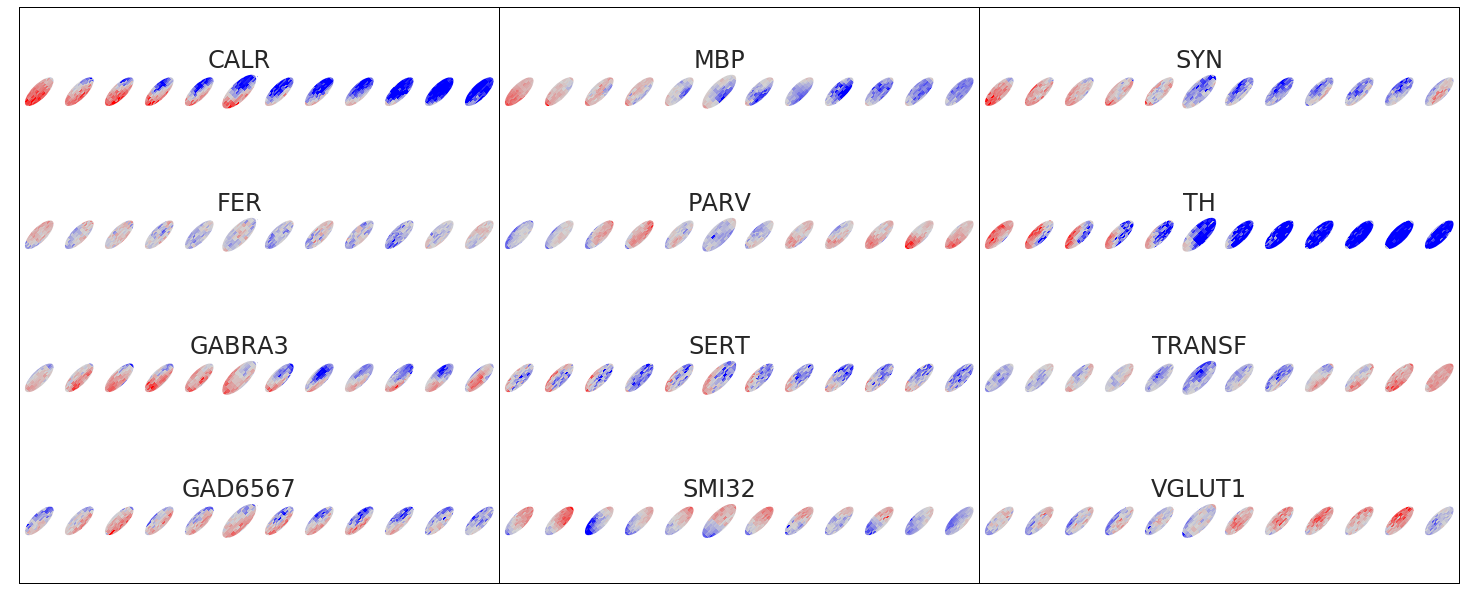

In [202]:
# Plot all stains together in a single figure
# Importing a number of different tools
from statsmodels.sandbox.stats import multicomp
import matplotlib
from matplotlib import patches
import scipy as sp
sns.set_style('white')
df.stain.unique()
%matplotlib inline

# gray 'background' of STN instead of white
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('colormap', ['blue', 'lightgray', 'red'])
def plot_ellipse_values(values, ellipse_pars=None, size=(1000, 1000), vmin=None, vmax=None, cmap=plt.cm.coolwarm, ax=None, **kwargs):

    ''' values is a n-by-m array'''

    values[np.isnan(values)] = 0
    if ellipse_pars is None:
        a = 350
        b = 150
        x = 500
        y = 500

        theta = 45. / 180 * np.pi

    else:
        a, b, x, y, theta = ellipse_pars

    A = a**2 * (np.sin(theta))**2 + b**2 * (np.cos(theta))**2
    B = 2 * (b**2 - a**2) * np.sin(theta) * np.cos(theta)
    C = a**2 * np.cos(theta)**2 + b**2 * np.sin(theta)**2
    D = -2 * A * x - B* y
    E = -B * x - 2 * C * y
    F = A* x**2 + B*x*y + C*y**2 - a**2*b**2

    X,Y = np.meshgrid(np.arange(size[0]), np.arange(size[1]))

    in_ellipse = A*X**2 + B*X*Y +C*Y**2 + D*X + E*Y +F < 0

    pc1 = np.array([[np.cos(theta)], [np.sin(theta)]])
    pc2 = np.array([[np.cos(theta - np.pi/2.)], [np.sin(theta - np.pi/2.)]])

    pc1_distance = pc1.T.dot(np.array([(X - x).ravel(), (Y - y).ravel()])).reshape(X.shape)
    pc2_distance = pc2.T.dot(np.array([(X - x).ravel(), (Y - y).ravel()])).reshape(X.shape)

    pc1_quantile = np.floor((pc1_distance / a + 1 ) / 2. * values.shape[0])
    pc2_quantile = np.floor((pc2_distance / b + 1 ) / 2. * values.shape[1])

    im = np.zeros_like(X, dtype=float)

    for pc1_q in np.arange(values.shape[0]):
        for pc2_q in np.arange(values.shape[1]):
            im[in_ellipse * (pc1_quantile == pc1_q) & (pc2_quantile == pc2_q)] = values[pc1_q, pc2_q]

    im = np.ma.masked_array(im, ~in_ellipse)
#     cmap.set_bad('grey')
    if ax is None:
        cax = plt.imshow(im, origin='lower', cmap=cmap, vmin=vmin, vmax=vmax, **kwargs)
    else:
        ax.imshow(im, origin='lower', cmap=cmap, vmin=vmin, vmax=vmax, **kwargs)
        cax = ax
#    sns.despine()

    return cax


# # What is the output folder for the PCA figures:
# pca_folder = '/home/mkeuken1/data/post_mortem/visualize_stains_v2/PCA_sectors/fwhm_%s' %fwhm
# if not os.path.exists(pca_folder):
#     os.makedirs(pca_folder) 

fig, axes = plt.subplots(nrows=4, ncols=3*n_sectors_per_axis)

y_type = 'rate_normalized'
# For every stain and sector over the 7 subjects plot the data and test whether it differs from zero:
for ii, (stain, d) in enumerate(df.groupby(['stain'])):
#         fn = '/home/mkeuken1/data/post_mortem/visualize_stains_v2/PCA_sectors/fwhm_%s/combined_big_picture_coolwarm.pdf' %(fwhm)
#         pdf = PdfPages(fn)
    column_set = int(np.floor(ii/4.))  # total number of columns required is n_stains / 4 (rows)
    row_n = int((ii)%4.)

    for i, (slice, d2) in enumerate(d.groupby('slice_3')):
        print(row_n, pma_labels[::-1].index(slice) + n_sectors_per_axis*(column_set))
        ax = axes[row_n, pma_labels[::-1].index(slice) + n_sectors_per_axis*(column_set)]

        n = d2.groupby(['pc1_3', 'pc2_3'])[y_type].apply(lambda v: len(v)).unstack(1).ix[vmd_labels, mml_labels] #['ventral', 'middle', 'dorsal'], ['medial', 'middle', 'lateral']]
        t = d2.groupby(['pc1_3', 'pc2_3'])[y_type].apply(lambda v: sp.stats.ttest_1samp(v, 0,nan_policy='omit')[0]).unstack(1).ix[vmd_labels, mml_labels]#['ventral', 'middle', 'dorsal'], ['medial', 'middle', 'lateral']]
        p = d2.groupby(['pc1_3', 'pc2_3'])[y_type].apply(lambda v: sp.stats.ttest_1samp(v, 0,nan_policy='omit')[1]).unstack(1).ix[vmd_labels, mml_labels]#['ventral', 'middle', 'dorsal'], ['medial', 'middle', 'lateral']]
        mean = d2.groupby(['pc1_3', 'pc2_3']).value.mean().unstack(1).ix[vmd_labels, mml_labels]#['ventral', 'middle', 'dorsal'], ['medial', 'middle', 'lateral']]

        # FDR: as we are doing 27 seperate t-tests we need to correct for multiple comparisons:
        p.values[:] = multicomp.fdrcorrection0(p.values.ravel())[1].reshape(n_sectors_per_axis, n_sectors_per_axis)

        # Providing some parameters for plotting the figures
        if i == len(d.groupby('slice_3'))/2:
            a, b, x, y, theta  = 350, 150, 300, 275, 45
        else:
            a, b, x, y, theta  = 300, 125, 300, 275, 45.

#         plot_ellipse_values(t[p<0.05].values, size=(600, 550), ellipse_pars=(a, b, x, y,  theta / 180. * np.pi), vmin=-7, vmax=7, cmap=cmap, ax=ax)
        plot_ellipse_values(t.values, size=(600, 550), ellipse_pars=(a, b, x, y,  theta / 180. * np.pi), vmin=-7, vmax=7, cmap=cmap, ax=ax)

        e1 = patches.Ellipse((x, y), a*2, b*2,
                             angle=theta, linewidth=2, fill=False, zorder=2)

        ax.add_patch(e1)
        ax.set_xticks([])
        ax.set_yticks([])

        sns.despine(bottom=True, left=True, right=True)

        if slice == pma_labels[int(n_sectors_per_axis/2)]: #'middle':
            ax.set_title(stain, fontsize=24)

#             print stain
#             print p.values

fig.set_size_inches(10.*2, 4.*2)
fig.subplots_adjust(hspace=.275, wspace=0.00, bottom=0.01, left=0.0, top=.95, right=1)

# outer boxes
plt.plot([0, 0], [0, 1], color='black', lw=1, transform=plt.gcf().transFigure, clip_on=False)
plt.plot([0, 1], [1, 1], color='black', lw=1, transform=plt.gcf().transFigure, clip_on=False)
plt.plot([1, 1], [0, 1], color='black', lw=1, transform=plt.gcf().transFigure, clip_on=False)
plt.plot([0, 1], [0, 0], color='black', lw=1, transform=plt.gcf().transFigure, clip_on=False)

# lines at 1/3rd, 2/3rd
plt.plot([1/3., 1/3.], [0, 1], color='black', lw=1, transform=plt.gcf().transFigure, clip_on=False)
plt.plot([2/3., 2/3.], [0, 1], color='black', lw=1, transform=plt.gcf().transFigure, clip_on=False)
#     fig.savefig(pdf,  format='pdf')#, bbox_inches='tight')
#     pdf.close()

/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


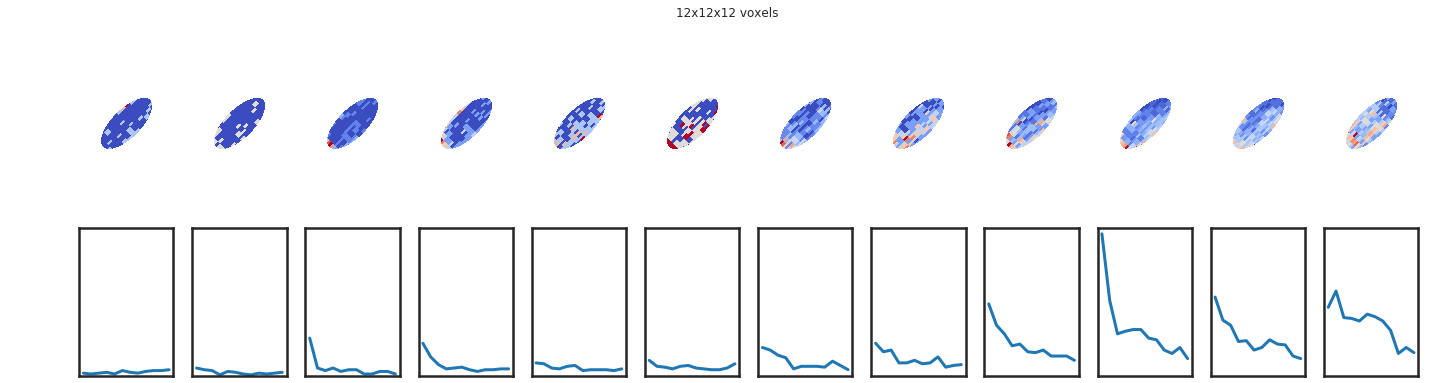

In [367]:
mml_labels = axis_labels['mml']
pma_labels = axis_labels['pma']
vmd_labels = axis_labels['vmd']

def visualize_intensity_across_space(df, dependent_var = 'y', per_slice = True):
            
    # loop
    if per_slice:  # (again ugly but ok)
        f, ax = plt.subplots(2, 12)
        for i, pma_slice in enumerate(pma_labels):
            idx = df.slice_3 == pma_slice
            
            unstacked = df.loc[idx].groupby(['pc1_3', 'pc2_3'])[dependent_var].mean().unstack(1).ix[vmd_labels, mml_labels]
            plot_ellipse_values(unstacked.values, ax=ax[0,i])
            ax[0,i].axis('off')

            # select values on mid-line of vmd-axis, so set mml to midline
            data_per_coordinate = df.loc[idx].groupby(['pc1_3_sector_coordinate'])[dependent_var].mean()
            ax[1,i].plot(np.arange(12), data_per_coordinate)

        y_lims = np.empty((12, 2))
        for sl in np.arange(12):
            y_lims[sl, 0] = ax[1,sl].get_ylim()[0]
            y_lims[sl, 1] = ax[1,sl].get_ylim()[1]

        for sl in np.arange(12):
            ax[1,sl].set_ylim([y_lims.min(0)[0], y_lims.max(0)[1]])
            ax[1,sl].tick_params(axis='x', which='both', bottom=False, top=False, left=False, labelbottom=False)
            ax[1,sl].get_yaxis().set_visible(False)
    else:
        f, ax = plt.subplots(2, 1)
        unstacked = df.groupby(['pc1_3', 'pc2_3'])[dependent_var].mean().unstack(1).ix[vmd_labels, mml_labels]
        plot_ellipse_values(unstacked.values, ax=ax[0])
        ax[0].axis('off')

        # select values on mid-line of vmd-axis, so set mml to midline
        data_per_coordinate = df.groupby(['pc1_3_sector_coordinate'])[dependent_var].mean()
        ax[1].plot(np.arange(12), data_per_coordinate)

    f.set_size_inches(ax.ravel().shape[0], 6)
    f.suptitle('12x12x12 voxels')
        
visualize_intensity_across_space(df.loc[(df.subject_id==13095) & (df.stain=='CALR')], per_slice=True)

## Model specifications

|Model N | Specification | Parameters | Interpretation |
|--------|:------------- |:---------- | ---------------|
| 1a | log(y) ~ 1, $\epsilon \sim Poisson$| $\beta_{intercept}$ | No change in expression across space |
| 1a | log(y) ~ 1, $\epsilon \sim NegativeBinomial$| $\beta_{intercept}$, $\alpha$ | No change in expression across space |
| 2a | log(y) ~ pc_1, $\epsilon \sim Poisson$ | $\beta_{intercept}$, $\beta_{pc_1}$ | Linear change across principal component 1 |
| 2b | log(y) ~ pc_1, $\epsilon \sim NegativeBinomial$ | $\beta_{intercept}$, $\beta_{pc_1}$, $\alpha$ | Linear change across principal component 1 |
| 3a | log(y) ~ sector, $\epsilon \sim Poisson$ | $\beta_{intercept}$, $\beta_{sector1}$, $\beta_{sector2}$ | 3 sectors, equisized
| 3b | log(y) ~ sector, $\epsilon \sim NegativeBinomial$ | $\beta_{intercept}$, $\beta_{sector1}$, $\beta_{sector2}$, $\alpha$ |  3 sectors, equisized
| 4a | log(y) ~ pc_1 + pc_2 + pc_3, $\epsilon \sim Poisson$ | $\beta_{intercept}$,  $\beta_{pc_1}$, $\beta_{pc_2}$, $\beta_{pc_3}$ |  Linear change in 3 directions
| 4b | log(y) ~ pc_1 + pc_2 + pc_3, $\epsilon \sim NegativeBinomial$ | $\beta_{intercept}$,  $\beta_{pc_1}$, $\beta_{pc_2}$, $\beta_{pc_3}$, $\alpha$ | Linear change in 3 directions
| 5a | log(y) ~ sector, $\epsilon \sim Poisson$ | $\beta_{intercept}$, $\beta_{sector1}$, $\beta_{sector2}$, cutoff1, cutoff2 | 3 sectors, cut-off estimated
| 5b | log(y) ~ sector, $\epsilon \sim NegativeBinomial$ | $\beta_{intercept}$, $\beta_{sector1}$, $\beta_{sector2}$, cutoff1, cutoff2, $\alpha$ |  3 sectors, cut-off estimated


In [236]:
# check-out distribution choice: does a Poisson distribution fit the data?

In [260]:
# exposure = df.loc[(df.subject_id==13095) & (df.stain=='CALR'), 'n_voxels'].copy().values
y = np.round(df.loc[(df.subject_id==13095) & (df.stain=='FER'), 'rate'].copy().values)

with pm.Model() as model:
    
    intercept = pm.Normal('intercept', mu=0, sd=10)
    
    ev = intercept
    likelihood = pm.Poisson('y', mu=np.exp(intercept), observed=y)
    
traces = pm.sample(model=model, tuning=1000, cores=18)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (18 chains in 18 jobs)
NUTS: [intercept]

Sampling 18 chains: 100%|██████████| 18000/18000 [00:12<00:00, 1429.25draws/s]The acceptance probability does not match the target. It is 0.8830559627332332, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8946822884846679, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.886890422651928, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8913136684699379, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8792750660137747, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probabil

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2bd7d34710>,
      dtype=object)

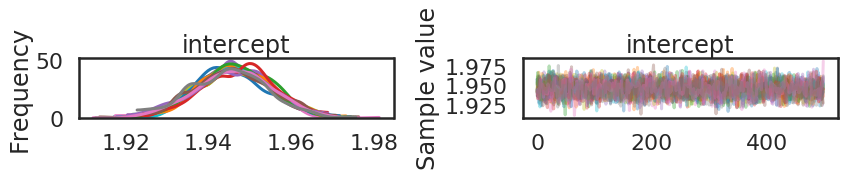

In [261]:
pm.traceplot(traces)

/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


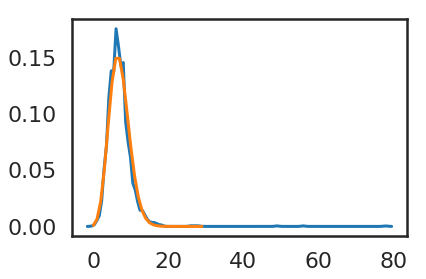

In [263]:
sns.kdeplot(np.round(y))
plt.plot(np.arange(30), sp.stats.poisson.pmf(np.arange(30), mu=np.exp(pm.summary(traces).loc['intercept', 'mean'])))

Ok, so at least model 1 seems to fit reasonably well. Poisson may not be such a bad choice

In [268]:
def get_single_stain_data(df, stain):
    return df.loc[df.stain==stain].copy()

In [354]:
df.head()

subject_id                   slice_3                    pc1_3  \
0       13095   pma_-0.4583333333333333  vmd_-0.4583333333333333   
1       13095                pma_-0.375  vmd_-0.4583333333333333   
2       13095  pma_-0.29166666666666663  vmd_-0.4583333333333333   
3       13095  pma_-0.20833333333333331  vmd_-0.4583333333333333   
4       13095                pma_-0.125  vmd_-0.4583333333333333   

                     pc2_3  n_voxels stain  value      rate  log_rate  \
0  mml_-0.4583333333333333       531  CALR    0.0  0.000000      -inf   
1  mml_-0.4583333333333333       536  CALR  577.0  1.076493  0.073708   
2  mml_-0.4583333333333333       305  CALR  797.0  2.613115  0.960543   
3  mml_-0.4583333333333333       702  CALR  855.0  1.217949  0.197168   
4  mml_-0.4583333333333333       377  CALR  762.0  2.021220  0.703701   

   rate_normalized  slice_3_sector_coordinate  pc1_3_sector_coordinate  \
0        -0.732601                  -0.458333                -0.458333   
1        -0.309994                  -0.375000                -0.458333   
2         0.293248                  -0.291667                -0.458333   
3        -0.254462                  -0.208333                -0.458333   
4         0.060884                  -0.125000                -0.458333   

   pc2_3_sector_coordinate pc_1_sectors  subject_id_2    y  
0                -0.458333            1             0  0.0  
1                -0.458333            1             0  1.0  
2                -0.458333            1             0  3.0  
3                -0.458333            1             0  1.0  
4                -0.458333            1             0  2.0

### Non-hierarchical

In [7]:
import pandas as pd
# Minor prepping of df
id_dict = dict([(id_old, id_new) for id_new, id_old in enumerate(df.subject_id.unique())])
df['subject_id_2'] = df['subject_id'].replace(id_dict)

# define y
df['y'] = np.round(df['rate'])

# Get sectors for Tripartite model
df['x_tripartite_axis_1'] = pd.qcut(df['pc1_3_sector_coordinate'].values, 3, labels=[1,2,3])
df['x_tripartite_axis_2'] = pd.qcut(df['pc2_3_sector_coordinate'].values, 3, labels=[1,2,3])
df['x_tripartite_axis_slice'] = pd.qcut(df['slice_3_sector_coordinate'].values, 3, labels=[1,2,3])

# get sector numbers
df['pc_1_sector_number'] = df['pc1_3_sector_coordinate'].replace(dict(zip(np.arange(df['pc1_3_sector_coordinate'].unique().shape[0]), df['pc1_3_sector_coordinate'].unique())))

In [41]:
# prep output dataframe
models = ['1', '2', '3', '4']
stains = df.stain.unique()
distributions = ['poisson', 'negative_binomial']
subjects = df.subject_id.unique()

model_flat_df = pd.DataFrame(columns=['model', 'trace'], 
                             index=pd.MultiIndex.from_product([subjects, distributions, stains, models], 
                                                               names=['subject_id', 'dist', 'stain', 'model_n']))

In [311]:
import pymc3 as pm
overwrite = False

for dist in distributions:
    for stain in stains:
        for subj in df.subject_id.unique():
            # select data / idx
            print('{} {} {}'.format(dist,stain,subj))
            y = np.round(df.loc[(df.subject_id==subj) & (df.stain==stain), 'rate'].copy().values)
            indx = (df.subject_id==subj) & (df.stain==stain)

            for model_n in [1,2,3,4]:
                
                # check if already exists
                if pd.notnull(model_flat_df.loc[((subj, dist, stain, str(model_n)), 'trace')]) and not overwrite:
                    continue

                print('Model {}'.format(model_n))
                with pm.Model() as model:
                    intercept = pm.Normal('intercept', mu=1, sd=3)
                    
                    if model_n == 1:
                        # no change
                        ev = np.exp(intercept)
                    
                    elif model_n == 2:
                        # gradient along pc axis 1
                        beta_pca_1 = pm.Normal('beta_pca_1', mu=0, sd=3)
                        ev = np.exp(intercept + beta_pca_1*df.loc[indx, 'pc1_3_sector_coordinate'].values)
                        
                    elif model_n == 3:
                        # 3 sectors along pc axis 1
                        delta_center_1 = pm.Normal('delta_center_1', mu=0, sd=3)
                        delta_center_3 = pm.Normal('delta_center_3', mu=0, sd=3)

                        ev = np.exp(intercept + \
                                    delta_center_1*((df.loc[indx, 'x_tripartite_axis_1'].values==1).astype(int)) + \
                                    delta_center_3*((df.loc[indx, 'x_tripartite_axis_1'].values==3).astype(int)))
                    
                    elif model_n == 4:
                        # gradient along pc axis 1+2+3
                        beta_pca_1 = pm.Normal('beta_pca_1', mu=0, sd=3)
                        beta_pca_2 = pm.Normal('beta_pca_2', mu=0, sd=3)
                        beta_slice = pm.Normal('beta_slice', mu=0, sd=3)

                        ev = np.exp(intercept + beta_pca_1*df.loc[indx, 'pc1_3_sector_coordinate'].values + \
                                    beta_pca_2*df.loc[indx, 'pc2_3_sector_coordinate'].values + \
                                    beta_slice*df.loc[indx, 'slice_3_sector_coordinate'].values)
                        
                    elif model_n == 5:
                        # 3 sectors along pc axis 1, cut-offs estimated
                        delta_center_1 = pm.Normal('delta_center_1', mu=0, sd=3)
                        delta_center_3 = pm.Normal('delta_center_3', mu=0, sd=3)

                        tau_1 = pm.Uniform('cut_off_1', 1, 6)
                        tau_2 = pm.Uniform('cut_off_2', 6, 11)
                        is_sector_1 = (df.loc[idx, 'pc1_sector_number'].values < tau_1).astype(int)
                        is_sector_3 = (df.loc[idx, 'pc1_sector_number'].values > tau_3).astype(int)
                        
                        ev = np.exp(intercept + \
                                    delta_center_1*is_sector_1 + \
                                    delta_center_3*is_sector_3)
                        
                    # define likelihood
                    if dist == 'poisson':
                        likelihood = pm.Poisson('y', mu=ev, observed=y)
                    else:
                        alpha = pm.HalfCauchy('alpha', beta=2)
                        likelihood = pm.NegativeBinomial('y', mu=ev, alpha=alpha, observed=y)
                        
                model.name = str(model_n) + '_' + dist
                model_flat_df.loc[((subj, dist, stain, str(model_n)), 'model')] = model
                traces = pm.sample(model=model, tuning=1000, cores=18)
                model_flat_df.loc[((subj, dist, stain, str(model_n)), 'trace')] = traces


negative_binomial CALR 13095
Model 1
Model 2
Model 3
Model 4
negative_binomial CALR 14037
Model 1
Model 2
Model 3
Model 4
negative_binomial CALR 14051
Model 1
Model 2
Model 3
Model 4
negative_binomial CALR 14069
Model 1
Model 2
Model 3
Model 4
negative_binomial CALR 15033
Model 1
Model 2
Model 3
Model 4
negative_binomial CALR 15055
Model 1
Model 2
Model 3
Model 4
negative_binomial FER 13095
Model 1
Model 2
Model 3
Model 4
negative_binomial FER 14037
Model 1
Model 2
Model 3
Model 4
negative_binomial FER 14051
Model 1
Model 2
Model 3
Model 4
negative_binomial FER 14069
Model 1
Model 2
Model 3
Model 4
negative_binomial FER 15033
Model 1
Model 2
Model 3
Model 4
negative_binomial FER 15055
Model 1
Model 2
Model 3
Model 4
negative_binomial GABRA3 13095
Model 1
Model 2
Model 3
Model 4
negative_binomial GABRA3 14037
Model 1
Model 2
Model 3
Model 4
negative_binomial GABRA3 14051
Model 1
Model 2
Model 3
Model 4
negative_binomial GABRA3 14069
Model 1
Model 2
Model 3
Model 4
negative_binomial GABR

output is no longer available but no fitting errors were reported (acceptance rate was typically higher than 0.8 but this shouldn't be an issue)

save all fitted models

In [225]:
import pickle as pkl
model_save_dir = './glm_models'
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)

model_flat_df2 = model_flat_df.copy()
model_flat_df2 = model_flat_df2.reset_index()  # reset index is easier

for row_n in np.arange(model_flat_df2.shape[0]):
    row = model_flat_df2.iloc[row_n]
    
    subj, dist, stain, model_n, model, trace = row[['subject_id', 'dist', 'stain', 'model_n', 'model', 'trace']].values
    with open(os.path.join(model_save_dir, 
                           'sub-{}_dist-{}_stain-{}_model-{}_model.pkl'.format(subj, dist, stain, model_n)), 'wb') as f:
        pkl.dump(model, f)

    with open(os.path.join(model_save_dir, 'sub-{}_dist-{}_stain-{}_model-{}_trace.pkl'.format(subj, dist, stain, model_n)), 'wb') as f:
        pkl.dump(trace, f)

In [312]:
model_flat_df

model  \
subject_id dist              stain   model_n                                                 
13095      poisson           CALR    1        <pymc3.model.Model object at 0x7f0bdcb03080>   
                                     2        <pymc3.model.Model object at 0x7f0be0294320>   
                                     3        <pymc3.model.Model object at 0x7f0be73a6dd8>   
                                     4        <pymc3.model.Model object at 0x7f0bdde55080>   
                             FER     1        <pymc3.model.Model object at 0x7f0c2f2070f0>   
                                     2        <pymc3.model.Model object at 0x7f0bf59c1fd0>   
                                     3        <pymc3.model.Model object at 0x7f0bf8d39080>   
                                     4        <pymc3.model.Model object at 0x7f0bf336dac8>   
                             GABRA3  1        <pymc3.model.Model object at 0x7f0c0102b9e8>   
                                     2        <pymc3.model.Model object at 0x7f0c439efe80>   
                                     3        <pymc3.model.Model object at 0x7f0c40d610b8>   
                                     4        <pymc3.model.Model object at 0x7f0c3ebea160>   
                             GAD6567 1        <pymc3.model.Model object at 0x7f0bf1578b00>   
                                     2        <pymc3.model.Model object at 0x7f0c01bac630>   
                                     3        <pymc3.model.Model object at 0x7f0bec2b7c88>   
                                     4        <pymc3.model.Model object at 0x7f0bf09240b8>   
                             MBP     1        <pymc3.model.Model object at 0x7f0bd9ebaba8>   
                                     2        <pymc3.model.Model object at 0x7f0bde45fb00>   
                                     3        <pymc3.model.Model object at 0x7f0b68ec5d30>   
                                     4        <pymc3.model.Model object at 0x7f0bc7eb41d0>   
                             PARV    1        <pymc3.model.Model object at 0x7f0bc66e75c0>   
                                     2        <pymc3.model.Model object at 0x7f0bc66517b8>   
                                     3        <pymc3.model.Model object at 0x7f0bc6551518>   
                                     4        <pymc3.model.Model object at 0x7f0bc640bf60>   
                             SERT    1        <pymc3.model.Model object at 0x7f0bc4bfd3c8>   
                                     2        <pymc3.model.Model object at 0x7f0bc4ae7438>   
                                     3        <pymc3.model.Model object at 0x7f0bc49d5748>   
                                     4        <pymc3.model.Model object at 0x7f0bc4896fd0>   
                             SMI32   1        <pymc3.model.Model object at 0x7f0bc3004198>   
                                     2        <pymc3.model.Model object at 0x7f0bc2fd6f98>   
...                                                                                    ...   
15055      negative_binomial MBP     3        <pymc3.model.Model object at 0x7f0b581ee668>   
                                     4        <pymc3.model.Model object at 0x7f0bf17d2e48>   
                             PARV    1        <pymc3.model.Model object at 0x7f0b694a9a58>   
                                     2        <pymc3.model.Model object at 0x7f0b6a109390>   
                                     3        <pymc3.model.Model object at 0x7f0b6ad63710>   
                                     4        <pymc3.model.Model object at 0x7f0b7b6764a8>   
                             SERT    1        <pymc3.model.Model object at 0x7f0bd2cc1048>   
                                     2        <pymc3.model.Model object at 0x7f0bd2a3d4e0>   
                                     3        <pymc3.model.Model object at 0x7f0bd2757dd8>   
                                     4        <pymc3.model.Model object at 0x7f0bd24a5dd8>   
                             SMI32   1     

#### Visually compare negative binomial vs poisson fit

The specimen & stains with higher expression rates are interesting to inspect

In [313]:
pm.summary(model_flat_df.loc[((15055, 'negative_binomial', 'CALR', '1'), 'trace')])

mean        sd  mc_error   hpd_2.5  hpd_97.5        n_eff  \
intercept  3.162914  0.013871  0.000137  3.136591  3.190592  9854.144847   
alpha      3.335166  0.128490  0.001413  3.093131  3.597172  9360.112536   

               Rhat  
intercept  0.999916  
alpha      1.000270

In [314]:
pm.summary(model_flat_df.loc[((15055, 'poisson', 'CALR', '1'), 'trace')])

mean        sd  mc_error   hpd_2.5  hpd_97.5        n_eff  \
intercept  3.162835  0.004884  0.000076  3.153937  3.173151  3321.402082   

               Rhat  
intercept  1.000179

In [315]:
pm.waic(trace=model_flat_df.loc[((15055, 'poisson', 'CALR', '1'), 'trace')], 
        model=model_flat_df.loc[((15055, 'poisson', 'CALR', '1'), 'model')])

WAIC_r(WAIC=21871.04904960245, WAIC_se=433.37881213096756, p_WAIC=7.9605333543778425, var_warn=0)

In [316]:
pm.waic(trace=model_flat_df.loc[((15055, 'negative_binomial', 'CALR', '1'), 'trace')], 
        model=model_flat_df.loc[((15055, 'negative_binomial', 'CALR', '1'), 'model')])

WAIC_r(WAIC=13599.588572678642, WAIC_se=59.81519638089132, p_WAIC=1.783560075843825, var_warn=0)

In [164]:
from scipy import special

def NegBinom(a, m, x):
    pmf = special.binom(x + a - 1, x) * (a / (m + a))**a * (m / (m + a))**x
    return pmf

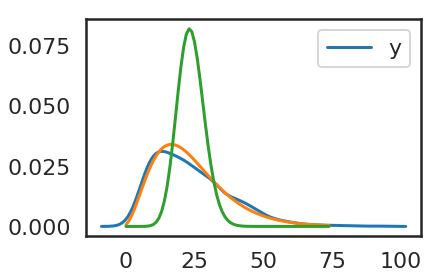

In [250]:
sns.kdeplot(df.loc[(df.subject_id==15055) & (df.stain == 'CALR'), 'y'])
plt.plot(np.arange(75), NegBinom(a=3.6, x=np.arange(75), m=np.exp(3.16)))
plt.plot(np.arange(75), sp.stats.poisson.pmf(np.arange(75), mu=np.exp(3.162835)))

for these larger expression values, a negative binomial clearly fits better than a poisson

Compare more formally. This takes a bit of time

In [340]:
def comp(x):
    if pd.isnull(x['trace']).sum()>0:
        return np.nan
    
    print('Comparing...')
    comparison = pm.compare(dict(zip(x['model'].values, x['trace'].values)))
    
    return comparison

compares = model_flat_df.reset_index()
compares['model_n'] = compares['model_n'] + '_' + compares ['dist']  # rename column
compares = compares.groupby(['subject_id', 'stain']).apply(lambda x: comp(x))

Comparing...


/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib

Comparing...


/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib

Comparing...


/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib

Comparing...
Comparing...


/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


Comparing...
Comparing...
Comparing...
Comparing...
Comparing...
Comparing...


/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib

Comparing...
Comparing...
Comparing...


/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib

Comparing...


/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib

Comparing...


/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib

Comparing...


/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib

Comparing...
Comparing...


/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib

Comparing...


/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib

Comparing...


/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


Comparing...
Comparing...


/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


Comparing...


/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


Comparing...


/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib

Comparing...


/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


Comparing...
Comparing...


/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


Comparing...


/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib

Comparing...
Comparing...
Comparing...
Comparing...
Comparing...


/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


Comparing...


/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib

Comparing...


/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


Comparing...
Comparing...
Comparing...


/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib

Comparing...
Comparing...


/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib

Comparing...


/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib

Comparing...
Comparing...


/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib

Comparing...


/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


Comparing...
Comparing...


/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib

Comparing...


/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


Comparing...
Comparing...
Comparing...
Comparing...
Comparing...


/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib

Comparing...


/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


Comparing...
Comparing...
Comparing...
Comparing...
Comparing...


/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib

Comparing...
Comparing...
Comparing...
Comparing...
Comparing...
Comparing...


/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


Comparing...


/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


Comparing...
Comparing...
Comparing...
Comparing...


/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


Comparing...


/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib

Comparing...
Comparing...


In [344]:
compares.to_pickle(os.path.join(model_save_dir, 'comparison.pkl'))

In [345]:
compares.loc[(13095, 'CALR')]

WAIC pWAIC    dWAIC weight      SE     dSE var_warn
4_negative_binomial  4999.79   6.6        0   0.01   93.63       0        1
4_poisson            5100.73  7.69   100.93   0.94  118.39   39.83        1
2_negative_binomial  6200.15  3.14  1200.35      0   86.65   59.09        0
3_negative_binomial     6234  4.18  1234.21      0   87.76   59.35        0
1_negative_binomial  6374.97  2.41  1375.17   0.01    92.5   61.22        0
2_poisson            7344.06  6.98  2344.26   0.05  193.06   155.9        1
3_poisson            7461.01  9.03  2461.21   0.01   205.9  168.28        1
1_poisson            7888.36  3.71  2888.56      0   248.1  210.43        0

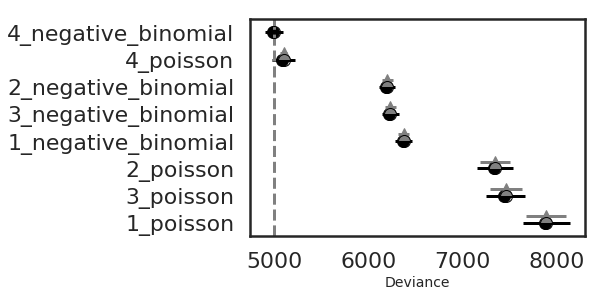

In [346]:
pm.compareplot(compares.loc[(13095, 'CALR')])

In [348]:
compares.index.set_names(['subject_id', 'stain', 'model_n'], inplace=True)
winning_models = compares.reset_index().groupby(['subject_id', 'stain']).apply(lambda x: x.model_n.iloc[0]).reset_index()
winning_models.columns = ['subject_id', 'stain', 'winner']
winning_models.pivot_table(index='subject_id', values='winner', columns='stain', aggfunc=lambda x: x)

stain                      CALR                  FER               GABRA3  \
subject_id                                                                  
13095       4_negative_binomial  4_negative_binomial  4_negative_binomial   
14037       4_negative_binomial  4_negative_binomial  4_negative_binomial   
14051       4_negative_binomial  4_negative_binomial  4_negative_binomial   
14069       4_negative_binomial  4_negative_binomial  4_negative_binomial   
15033       4_negative_binomial  4_negative_binomial  4_negative_binomial   
15055       4_negative_binomial  4_negative_binomial  4_negative_binomial   

stain                   GAD6567                  MBP                 PARV  \
subject_id                                                                  
13095       4_negative_binomial  4_negative_binomial  4_negative_binomial   
14037       4_negative_binomial  4_negative_binomial  4_negative_binomial   
14051       4_negative_binomial  4_negative_binomial  4_negative_binomial   
14069       4_negative_binomial  4_negative_binomial  4_negative_binomial   
15033                 4_poisson  3_negative_binomial  4_negative_binomial   
15055       4_negative_binomial  4_negative_binomial  4_negative_binomial   

stain                      SERT                SMI32                  SYN  \
subject_id                                                                  
13095       4_negative_binomial  4_negative_binomial  4_negative_binomial   
14037                 4_poisson  4_negative_binomial  4_negative_binomial   
14051       4_negative_binomial  4_negative_binomial  4_negative_binomial   
14069       4_negative_binomial  4_negative_binomial  4_negative_binomial   
15033                 4_poisson  4_negative_binomial  4_negative_binomial   
15055                 4_poisson  4_negative_binomial  4_negative_binomial   

stain                        TH               TRANSF               VGLUT1  
subject_id                                                                 
13095       4_negative_binomial  4_negative_binomial  3_negative_binomial  
14037       4_negative_binomial  4_negative_binomial  4_negative_binomial  
14051       4_negative_binomial  4_negative_binomial            4_poisson  
14069       4_negative_binomial  4_negative_binomial  4_negative_binomial  
15033       4_negative_binomial  4_negative_binomial  4_negative_binomial  
15055       4_negative_binomial  4_negative_binomial  4_negative_binomial

Interesting: By far most prefer model 4 with negative binomial distributed errors. What about the other ones?

Especially inspect 15033/MBP and 13095/VGLUT1

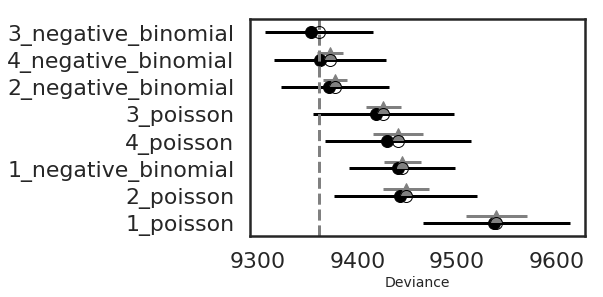

In [341]:
pm.compareplot(compares.loc[(13095, 'VGLUT1')])

/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:32: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


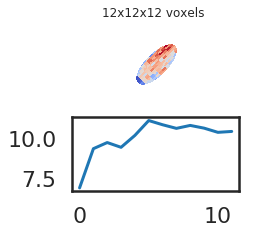

In [370]:
visualize_intensity_across_space(df.loc[(df.subject_id==13095) & (df.stain=='VGLUT1')], per_slice=False)
plt.gcf().set_size_inches(3,3)

Here, apparently a 3-partite model fits better than a linear gradient

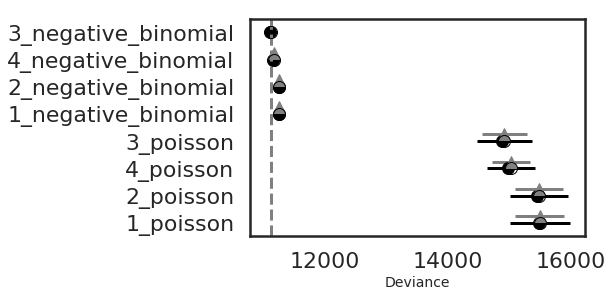

In [376]:
pm.compareplot(compares.loc[(15033, 'MBP')])

/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:32: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


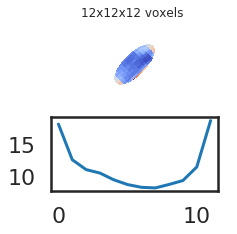

In [375]:
visualize_intensity_across_space(df.loc[(df.subject_id==15033) & (df.stain=='MBP')], per_slice=False)
plt.gcf().set_size_inches(3,3)

Given this rather interesting U-shape, no wonder a three-partite model fits better than a line...

### Hierarchical models

I did some attempts at fitting an hierarchical model but can't get sampling to work well

In [111]:
def get_single_stain_data(df, stain):
    return df.loc[df.stain==stain].copy()

In [113]:
# make output dataframes
import pandas as pd

models = ['1', '2', '3', '4']
stains = df.stain.unique()
distributions = ['negative_binomial', 'poisson']
model_df = pd.DataFrame(columns=stains, index=pd.MultiIndex.from_product([models, distributions], names=['model_n', 'dist']))
traces_df = model_df.copy()

In [207]:
## hierarchical
### Model definitions
from collections import OrderedDict
import pymc3 as pm

for dist in distributions:#, 'log']:
    for stain in df.stain.unique():
        print('.', end='')
        data_stain = get_single_stain_data(df, stain)
        
        for model_n in [1,2,3,4]:
            with pm.Model() as model:
                # Assume mu is gamma-distributed (?)
                alpha = pm.Gamma('pop_alpha', .01, .01)
                beta = pm.Gamma('pop_beta', .01, .01)

                intercept = pm.Gamma('mu_intercept', alpha, beta, shape=len(data_stain.subject_id.unique()))

                if model_n == 1:
                    # Expected value
                    y_est = intercept[data_stain.subject_id_2.values]
                    
                elif model_n == 2:
                    mu_beta_pca_1 = pm.Normal('mu_pca_1_intercept', mu=0, sd=2)
                    sigma_beta_pca_1 = pm.HalfCauchy('sigma_beta_pca_1', beta=1)

                    beta_pca_1_offset = pm.Normal('beta_pca_1_offset', mu=mu_beta_pca_1, sd=sigma_beta_pca_1, 
                                                  shape=len(data_stain.subject_id.unique()))
                    beta_pca_1 = pm.Deterministic('beta_pca_1', mu_beta_pca_1 + beta_pca_1_offset*sigma_beta_pca_1)

                    y_est = intercept[data_stain.subject_id_2.values] * \  #
                            np.exp(beta_pca_1[data_stain.subject_id_2.values]*data_stain['pc1_3_sector_coordinate'].values)

                elif model_n == 3:
                    mu_delta_center_1 = pm.Normal('mu_delta_center_1', mu=0, sd=2)
                    sigma_delta_center_1 = pm.HalfCauchy('sigma_delta_center_1', beta=2)

                    mu_delta_center_3 = pm.Normal('mu_delta_center_3', mu=0, sd=2)
                    sigma_delta_center_3 = pm.HalfCauchy('sigma_delta_center_3', beta=2)

                    # non-centered specification of individual params
                    dummy_center_1_offset = pm.Normal('dummy_center_1_offset', mu=mu_delta_center_1, sd=sigma_delta_center_1, shape=len(data_stain.subject_id.unique()))
                    dummy_center_1 = pm.Deterministic('dummy_center_1', mu_delta_center_1 + dummy_center_1_offset*sigma_delta_center_1)

                    dummy_center_3_offset = pm.Normal('dummy_center_3_offset', mu=mu_delta_center_3, sd=sigma_delta_center_3, shape=len(data_stain.subject_id.unique()))
                    dummy_center_3 = pm.Deterministic('dummy_center_3', mu_delta_center_3 + dummy_center_3_offset*sigma_delta_center_3)
                    
                    y_est = intercept[data_stain.subject_id_2.values] * \
                            (np.exp(dummy_center_1[data_stain.subject_id_2.values]*(data_stain['x_tripartite_axis_1']==1).astype(int))) * \
                            (np.exp(dummy_center_3[data_stain.subject_id_2.values]*(data_stain['x_tripartite_axis_1']==3).astype(int)))
                
                elif model_n == 4:
                    mu_beta_pca_1 = pm.Normal('mu_pca_1_intercept', mu=0, sd=2)
                    sigma_beta_pca_1 = pm.HalfCauchy('sigma_beta_pca_1', beta=2)

                    mu_beta_pca_2 = pm.Normal('mu_pca_2_intercept', mu=0, sd=2)
                    sigma_beta_pca_2 = pm.HalfCauchy('sigma_beta_pca_2', beta=2)

                    mu_beta_pca_3 = pm.Normal('mu_pca_3_intercept', mu=0, sd=2)
                    sigma_beta_pca_3 = pm.HalfCauchy('sigma_beta_pca_3', beta=2)

                    beta_pca_1_offset = pm.Normal('beta_pca_1_offset', mu=mu_beta_pca_1, sd=sigma_beta_pca_1, shape=len(data_stain.subject_id.unique()))
                    beta_pca_1 = pm.Deterministic('beta_pca_1', mu_beta_pca_1 + beta_pca_1_offset*sigma_beta_pca_1)

                    beta_pca_2_offset = pm.Normal('beta_pca_2_offset', mu=mu_beta_pca_2, sd=sigma_beta_pca_2, shape=len(data_stain.subject_id.unique()))
                    beta_pca_2 = pm.Deterministic('beta_pca_2', mu_beta_pca_2 + beta_pca_2_offset*sigma_beta_pca_2)

                    beta_pca_3_offset = pm.Normal('beta_pca_3_offset', mu=mu_beta_pca_3, sd=sigma_beta_pca_3, shape=len(data_stain.subject_id.unique()))
                    beta_pca_3 = pm.Deterministic('beta_pca_3', mu_beta_pca_3 + beta_pca_3_offset*sigma_beta_pca_3)

                    # Expected value
                    y_est = intercept[data_stain.subject_id_2.values] * \
                            np.exp(beta_pca_1[data_stain.subject_id_2.values]*data_stain['pc1_3_sector_coordinate']) + \
                            np.exp(beta_pca_2[data_stain.subject_id_2.values]*data_stain['pc2_3_sector_coordinate']) + \
                            np.exp(beta_pca_3[data_stain.subject_id_2.values]*data_stain['slice_3_sector_coordinate'])
                
                # likelihood is the same for all models - except that y_est changes
                if dist == 'poisson':
                    likelihood = pm.Poisson('y', mu=y_est, observed=data_stain['y'])
                elif dist == 'negative_binomial':
                    alpha = pm.HalfCauchy('alpha', beta=10)
                    likelihood = pm.NegativeBinomial('y', mu=y_est, alpha=alpha, observed=data_stain['y'])
            
            model.name = str(model_n) + '_' + dist
            model_df.loc[((str(model_n), dist), stain)] = model

model_df.head()

..

CALR  FER  \
model_n dist                                                                   
1       negative_binomial  <pymc3.model.Model object at 0x7f0c4f93cba8>  NaN   
        poisson            <pymc3.model.Model object at 0x7f0c438d8eb8>  NaN   
2       negative_binomial  <pymc3.model.Model object at 0x7f0c4e925128>  NaN   
        poisson            <pymc3.model.Model object at 0x7f0c433c6dd8>  NaN   
3       negative_binomial  <pymc3.model.Model object at 0x7f0c52fe34e0>  NaN   

                          GABRA3 GAD6567  MBP PARV SERT SMI32  SYN   TH  \
model_n dist                                                              
1       negative_binomial    NaN     NaN  NaN  NaN  NaN   NaN  NaN  NaN   
        poisson              NaN     NaN  NaN  NaN  NaN   NaN  NaN  NaN   
2       negative_binomial    NaN     NaN  NaN  NaN  NaN   NaN  NaN  NaN   
        poisson              NaN     NaN  NaN  NaN  NaN   NaN  NaN  NaN   
3       negative_binomial    NaN     NaN  NaN  NaN  NaN   NaN  NaN  NaN   

                          TRANSF VGLUT1  
model_n dist                             
1       negative_binomial    NaN    NaN  
        poisson              NaN    NaN  
2       negative_binomial    NaN    NaN  
        poisson              NaN    NaN  
3       negative_binomial    NaN    NaN

In [208]:
stains_to_run = df.stain.unique()
models_to_run = [4, 3, 2, 1]  #,3,4]
dists = ['negative_binomial']  #poisson']
overwrite = True

for stain in stains_to_run:
    for model_n in models_to_run:
        for dist in dists:
            
            print('running stain {}, model {}, {} distribution'.format(stain, str(model_n), dist))
            if pd.notnull(traces_df.loc[(str(model_n), dist), stain]) and not overwrite:
                print('Already ran, skipping...')
                # already run?
                continue
            
            this_model = model_df.loc[(str(model_n), dist), stain]
            trace = pm.sample(model=this_model, cores=18, target_accept=.9, tune=1000)
            traces_df.loc[(str(model_n), dist), stain] = trace

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /home/mkeuken1/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.8-64/lock_dir/lock


running stain CALR, model 4, negative_binomial distribution


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, eps, beta_pca_3_offset, beta_pca_2_offset, beta_pca_1_offset, sigma_beta_pca_3, mu_pca_3_intercept, sigma_beta_pca_2, mu_pca_2_intercept, sigma_beta_pca_1, mu_pca_1_intercept, mu_intercept, pop_beta, pop_alpha]
Sampling 2 chains:  40%|████      | 802/2000 [05:54<08:49,  2.26draws/s]


ValueError: Not enough samples to build a trace.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0c7bd045f8>,
      dtype=object)

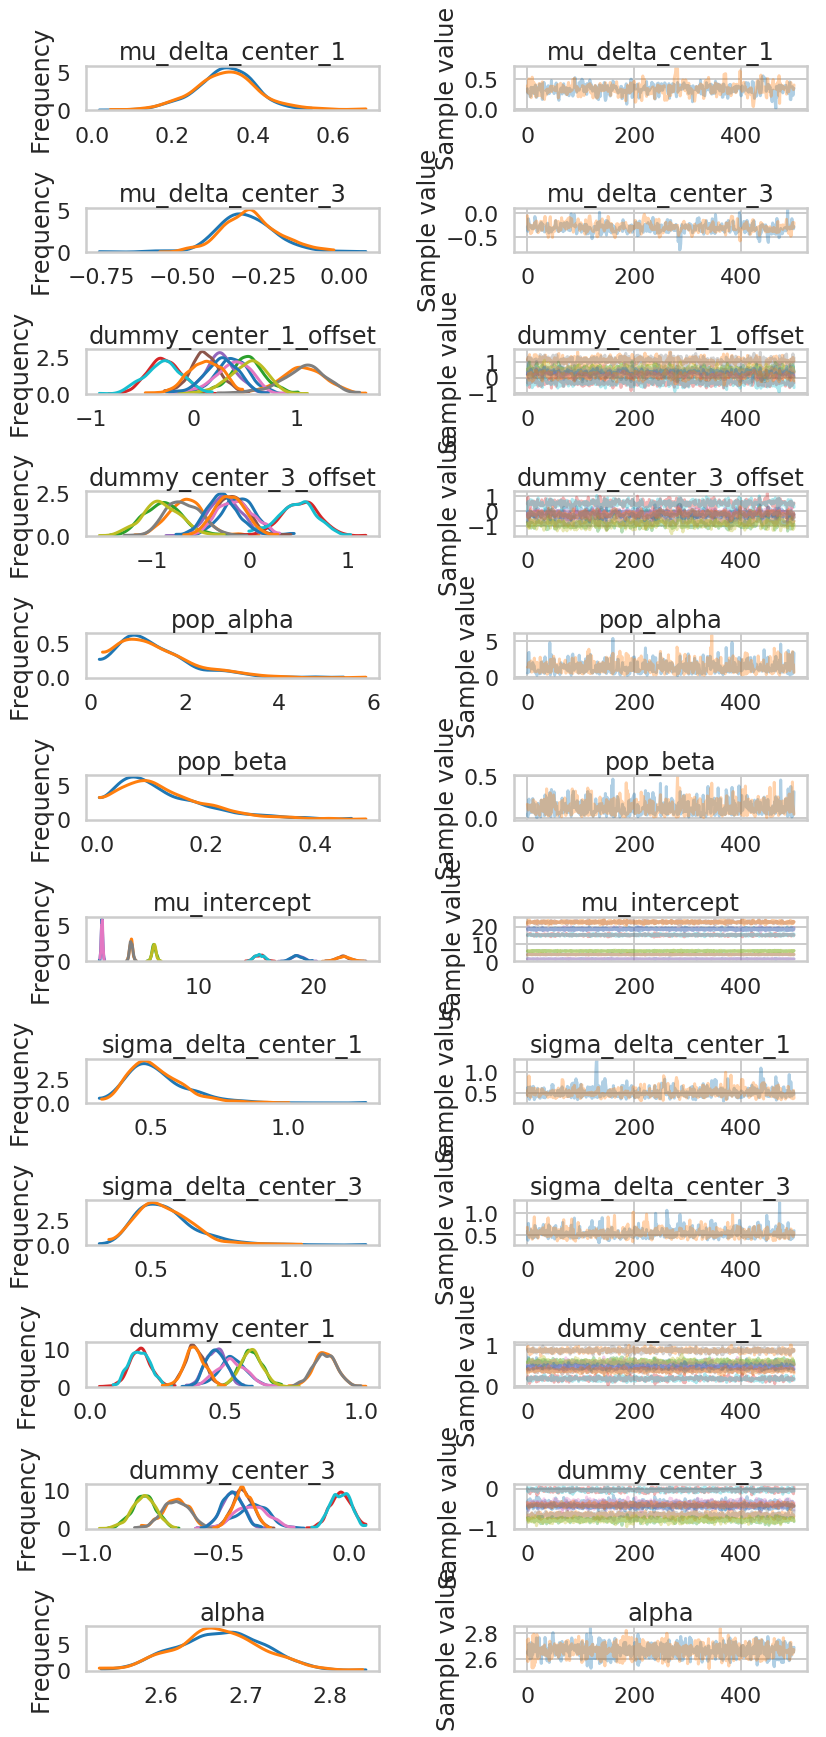

In [199]:
pm.traceplot(traces_df.loc[(('3', 'negative_binomial'), 'CALR')])

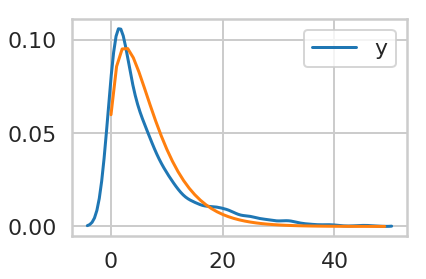

In [175]:
sns.kdeplot(data_stain.loc[data_stain.subject_id_2==2, 'y'])
plt.plot(np.arange(50), NegBinom(x=np.arange(50), m=6.725157, a=1.819402))

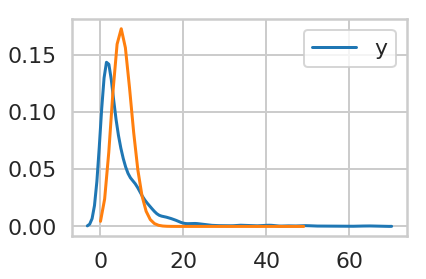

In [139]:
sns.kdeplot(data_stain.loc[data_stain.subject_id_2==1, 'y'])
plt.plot(np.arange(50), sp.stats.poisson.pmf(np.arange(50), 5.424135))

In [185]:
pm.summary(traces_df.loc[(('2', 'negative_binomial'), 'CALR')])

mean        sd  mc_error    hpd_2.5   hpd_97.5  \
mu_pca_1_intercept    -2.063537  0.457158  0.022555  -2.920911  -1.119965   
beta_pca_1_offset__0  -0.137709  0.286486  0.012399  -0.658022   0.481449   
beta_pca_1_offset__1  -2.460064  0.344512  0.016230  -3.108396  -1.818203   
beta_pca_1_offset__2  -2.421623  0.341354  0.015927  -3.013655  -1.718618   
beta_pca_1_offset__3  -1.116161  0.330490  0.013747  -1.726183  -0.435636   
beta_pca_1_offset__4  -3.472154  0.472157  0.022562  -4.319742  -2.446254   
beta_pca_1_offset__5  -3.450890  0.464942  0.022206  -4.248645  -2.462201   
pop_alpha              0.949930  0.471038  0.017618   0.126206   1.796496   
pop_beta               0.102983  0.065083  0.002398   0.000897   0.218122   
mu_intercept__0        0.618748  0.037836  0.001101   0.535968   0.686338   
mu_intercept__1        2.366468  0.073117  0.002013   2.231514   2.503279   
mu_intercept__2        3.685110  0.096544  0.002993   3.490283   3.859325   
mu_intercept__3       14.452247  0.290863  0.009631  13.854041  14.999537   
mu_intercept__4       14.912142  0.292444  0.007634  14.342104  15.504576   
mu_intercept__5       18.551192  0.354775  0.011231  17.744024  19.197920   
sigma_beta_pca_1       1.505693  0.274046  0.014616   1.080904   2.105506   
beta_pca_1__0         -2.307138  0.115804  0.003598  -2.527304  -2.079771   
beta_pca_1__1         -5.703141  0.111169  0.003652  -5.905369  -5.470763   
beta_pca_1__2         -5.647621  0.125509  0.003370  -5.893346  -5.413536   
beta_pca_1__3         -3.729731  0.382343  0.012287  -4.385521  -2.889327   
beta_pca_1__4         -7.185343  0.162314  0.004922  -7.479888  -6.834044   
beta_pca_1__5         -7.156041  0.168450  0.004801  -7.470918  -6.833537   
alpha                  2.667422  0.050812  0.001483   2.564212   2.761718   

                            n_eff      Rhat  
mu_pca_1_intercept     398.512090  1.001906  
beta_pca_1_offset__0   512.241146  1.001266  
beta_pca_1_offset__1   341.735990  1.001265  
beta_pca_1_offset__2   351.413250  1.003168  
beta_pca_1_offset__3   566.046744  1.000473  
beta_pca_1_offset__4   341.961952  1.000858  
beta_pca_1_offset__5   331.877917  1.000575  
pop_alpha              760.266622  0.999413  
pop_beta               751.633591  0.999024  
mu_intercept__0       1208.855354  1.000311  
mu_intercept__1       1185.576038  0.999316  
mu_intercept__2       1032.135461  0.999751  
mu_intercept__3        973.505639  0.999253  
mu_intercept__4       1465.745494  0.999786  
mu_intercept__5       1084.945865  0.999566  
sigma_beta_pca_1       300.929770  0.999401  
beta_pca_1__0         1088.140078  0.999173  
beta_pca_1__1          975.924503  0.999533  
beta_pca_1__2         1138.899548  1.000119  
beta_pca_1__3          970.231210  0.999147  
beta_pca_1__4         1049.642796  0.999055  
beta_pca_1__5         1097.482037  0.999099  
alpha                 1315.718106  1.001587

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0c7ab2ae80>,
      dtype=object)

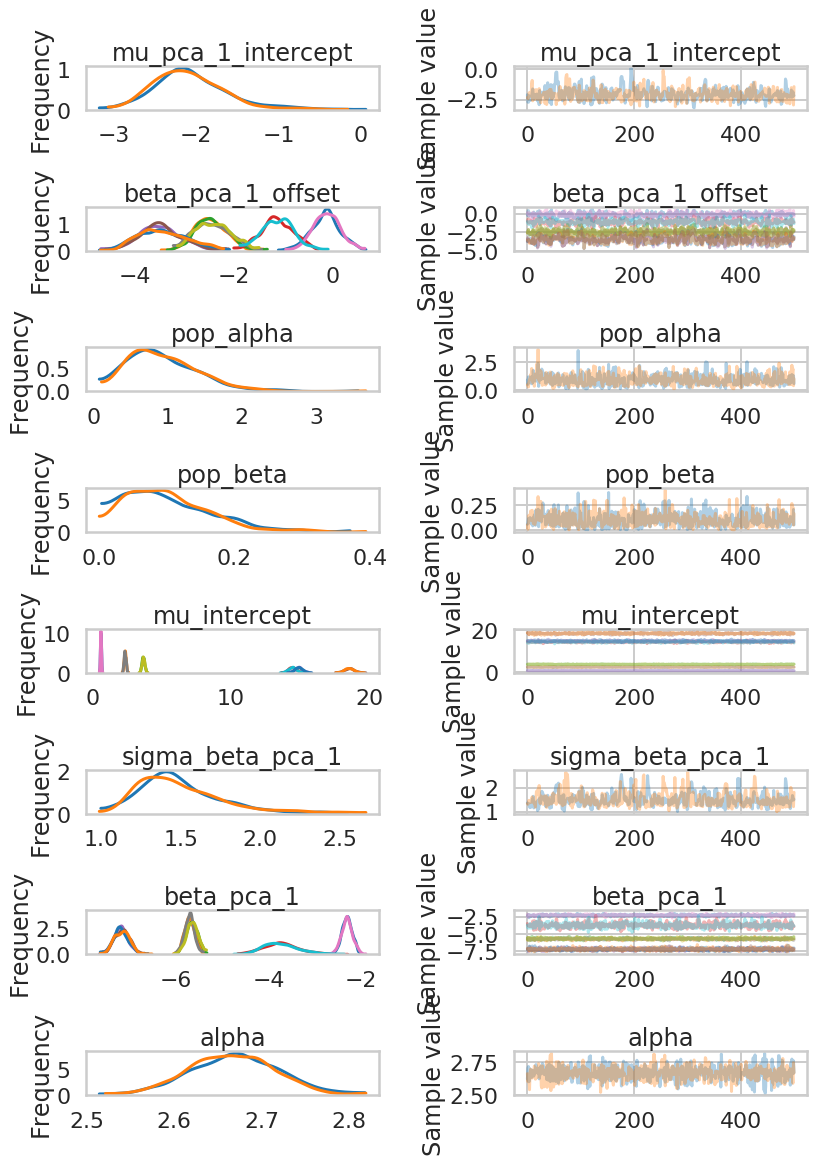

In [187]:
pm.traceplot(traces_df.loc[(('2', 'negative_binomial'), 'CALR')])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2bcde25978>,
      dtype=object)

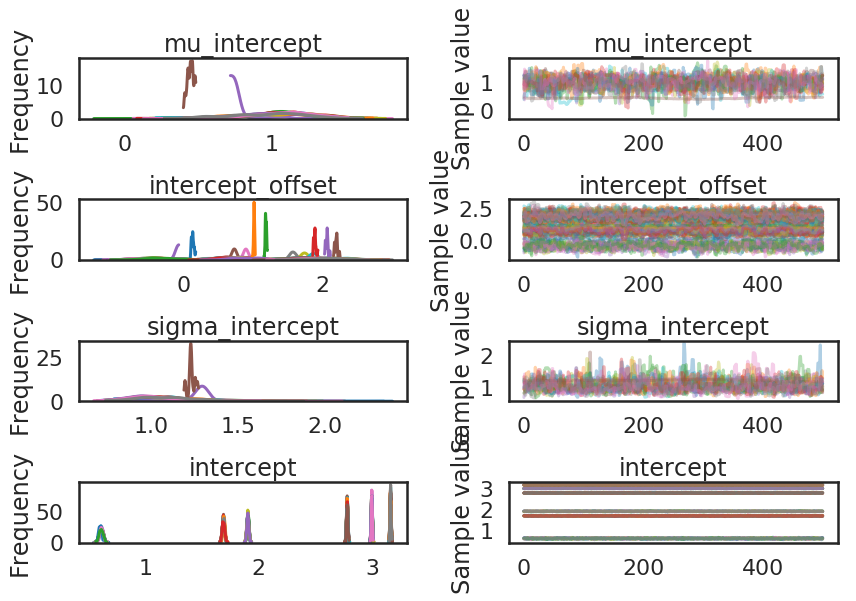

In [281]:
pm.traceplot(trace)

In [390]:
df.groupby(['subject_id', 'stain']).value.min()

subject_id  stain  
13095       CALR       5.401682e-08
            FER        1.493662e+00
            GABRA3     1.789251e-01
            GAD6567    7.217613e-06
            MBP        1.572817e-01
            PARV       6.335640e-02
            SERT       3.605445e-01
            SMI32      2.421312e-01
            SYN        9.014705e-01
            TH         0.000000e+00
            TRANSF     1.513548e+00
            VGLUT1     9.184465e-01
14037       CALR       1.586169e-03
            FER        5.228443e+00
            GABRA3     1.829381e+00
            GAD6567    5.373947e-01
            MBP        6.521627e-01
            PARV       2.807160e-01
            SERT       1.851284e-01
            SMI32      6.095462e+00
            SYN        1.736851e+00
            TH         2.046098e-06
            TRANSF     5.476191e+00
            VGLUT1     7.800327e+00
14051       CALR       5.010041e-03
            FER        4.084007e+00
            GABRA3     1.770330e-04
        

In [386]:
df['value_log'].min()

-inf

In [387]:
sns.kd2plot(df['value_log'])

AttributeError: module 'seaborn' has no attribute 'kd2plot'

In [281]:
traces_df

CALR  FER GABRA3  \
model_n value                                                                  
1       raw    ({'intercept_offset': [0.014111253562102744, 0...  NaN    NaN   
        log    ({'intercept_offset': [-0.0023900833573425387,...  NaN    NaN   
2       raw    ({'mu_intercept': 0.005210482811349724, 'sigma...  NaN    NaN   
        log    ({'mu_intercept': -0.005920638490296717, 'sigm...  NaN    NaN   
3       raw    ({'mu_intercept': -0.07102119472253483, 'sigma...  NaN    NaN   
        log                                                  NaN  NaN    NaN   
4       raw                                                  NaN  NaN    NaN   
        log                                                  NaN  NaN    NaN   

              GAD6567  MBP PARV SERT SMI32  SYN   TH TRANSF VGLUT1  
model_n value                                                       
1       raw       NaN  NaN  NaN  NaN   NaN  NaN  NaN    NaN    NaN  
        log       NaN  NaN  NaN  NaN   NaN  NaN  NaN    NaN    NaN  
2       raw       NaN  NaN  NaN  NaN   NaN  NaN  NaN    NaN    NaN  
        log       NaN  NaN  NaN  NaN   NaN  NaN  NaN    NaN    NaN  
3       raw       NaN  NaN  NaN  NaN   NaN  NaN  NaN    NaN    NaN  
        log       NaN  NaN  NaN  NaN   NaN  NaN  NaN    NaN    NaN  
4       raw       NaN  NaN  NaN  NaN   NaN  NaN  NaN    NaN    NaN  
        log       NaN  NaN  NaN  NaN   NaN  NaN  NaN    NaN    NaN

In [282]:
traces_df[stain]

model_n  value
1        raw      ({'intercept_offset': [0.014111253562102744, 0...
         log      ({'intercept_offset': [-0.0023900833573425387,...
2        raw      ({'mu_intercept': 0.005210482811349724, 'sigma...
         log      ({'mu_intercept': -0.005920638490296717, 'sigm...
3        raw      ({'mu_intercept': -0.07102119472253483, 'sigma...
         log                                                    NaN
4        raw                                                    NaN
         log                                                    NaN
Name: CALR, dtype: object

In [287]:
traces_df[]

CALR  FER GABRA3  \
model_n value                                                                  
1       raw    ({'intercept_offset': [0.014111253562102744, 0...  NaN    NaN   
        log    ({'intercept_offset': [-0.0023900833573425387,...  NaN    NaN   
2       raw    ({'mu_intercept': 0.005210482811349724, 'sigma...  NaN    NaN   
        log    ({'mu_intercept': -0.005920638490296717, 'sigm...  NaN    NaN   
3       raw    ({'mu_intercept': -0.07102119472253483, 'sigma...  NaN    NaN   
        log                                                  NaN  NaN    NaN   
4       raw                                                  NaN  NaN    NaN   
        log                                                  NaN  NaN    NaN   

              GAD6567  MBP PARV SERT SMI32  SYN   TH TRANSF VGLUT1  
model_n value                                                       
1       raw       NaN  NaN  NaN  NaN   NaN  NaN  NaN    NaN    NaN  
        log       NaN  NaN  NaN  NaN   NaN  NaN  NaN    NaN    NaN  
2       raw       NaN  NaN  NaN  NaN   NaN  NaN  NaN    NaN    NaN  
        log       NaN  NaN  NaN  NaN   NaN  NaN  NaN    NaN    NaN  
3       raw       NaN  NaN  NaN  NaN   NaN  NaN  NaN    NaN    NaN  
        log       NaN  NaN  NaN  NaN   NaN  NaN  NaN    NaN    NaN  
4       raw       NaN  NaN  NaN  NaN   NaN  NaN  NaN    NaN    NaN  
        log       NaN  NaN  NaN  NaN   NaN  NaN  NaN    NaN    NaN

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb4d37539e8>,
      dtype=object)

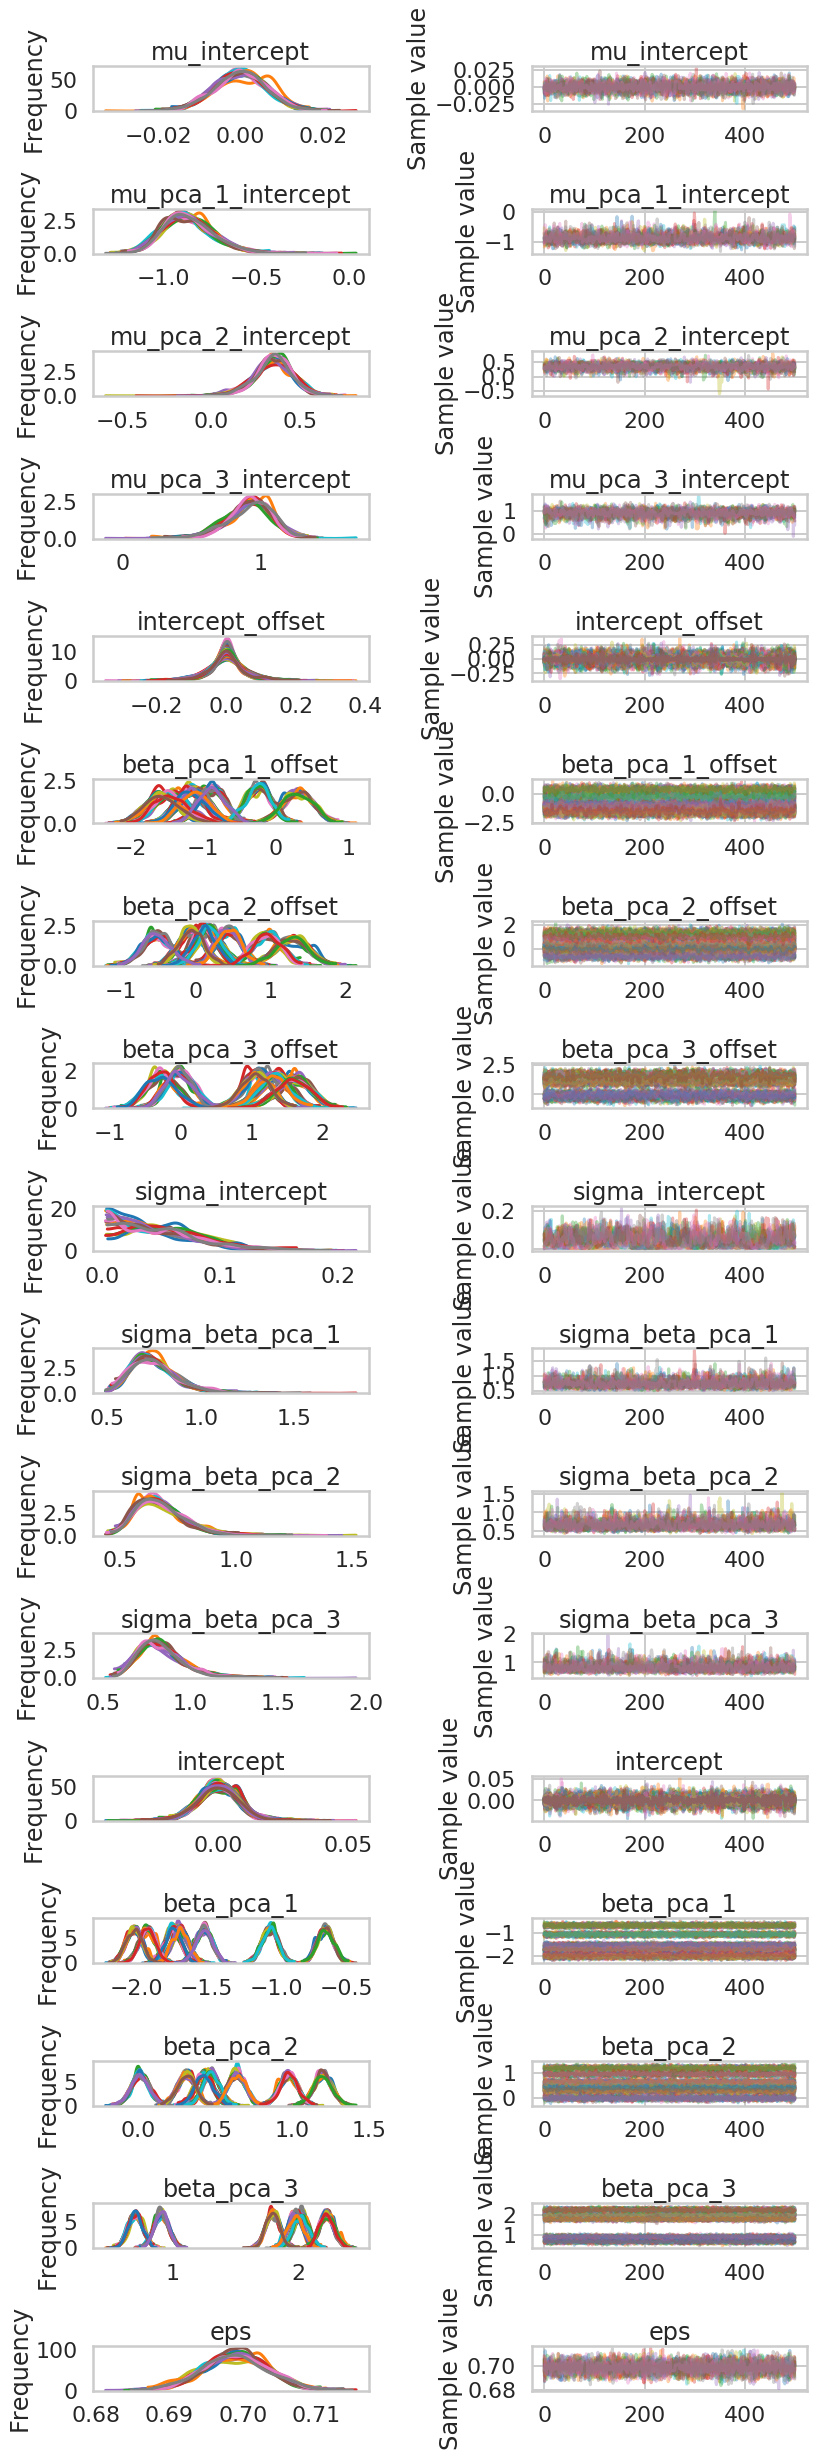

In [310]:
pm.traceplot(traces_df.loc[(('4', 'raw'), 'CALR')])

In [294]:
stain = 'CALR'
waic_comp = pm.compare(dict(zip(model_df[pd.notnull(traces_df[stain])][stain], traces_df[pd.notnull(traces_df[stain])][stain])))

/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib

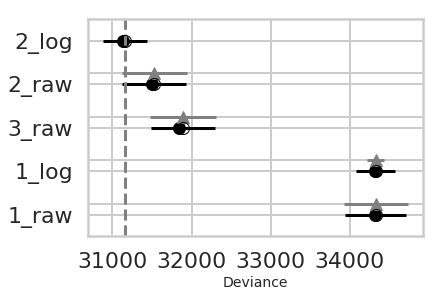

In [295]:
pm.compareplot(waic_comp)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb5269c6fd0>,
      dtype=object)

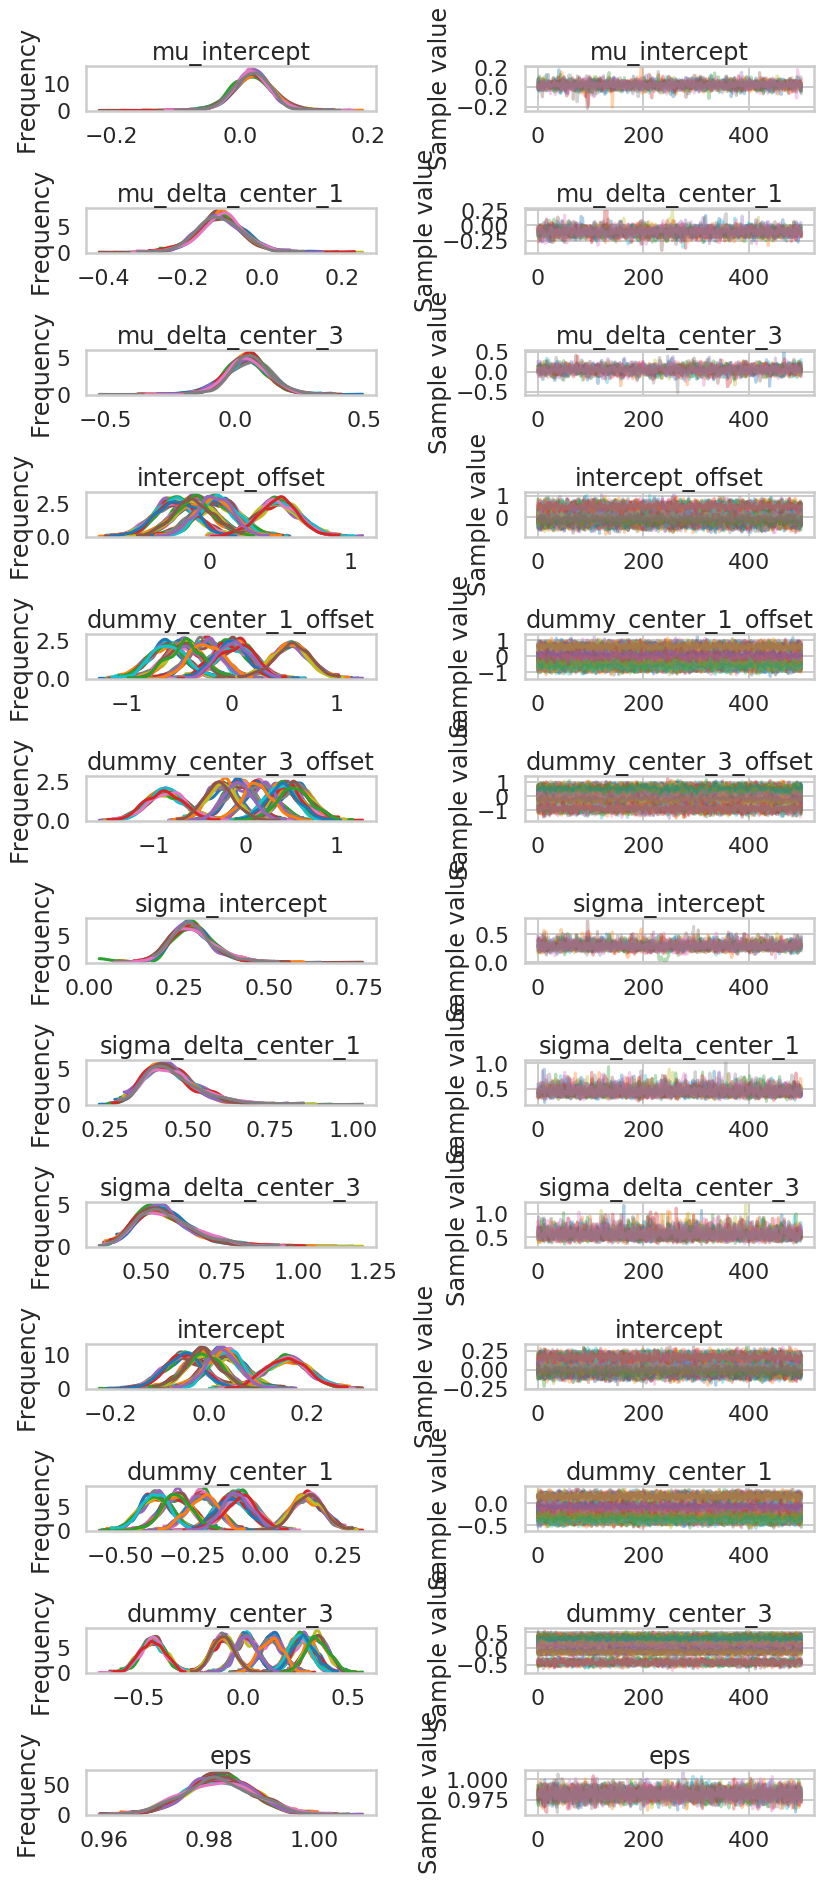

In [259]:

traceplot(traces_df.loc[(('3', 'log'), 'FER')])

/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:299: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:299: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
      

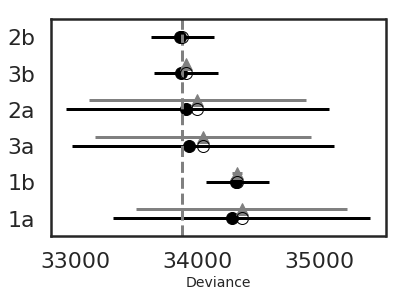

In [118]:
# model comparison
comp_loo = pm.compare(model_traces, ic='LOO')
pm.compareplot(comp_loo)


/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib

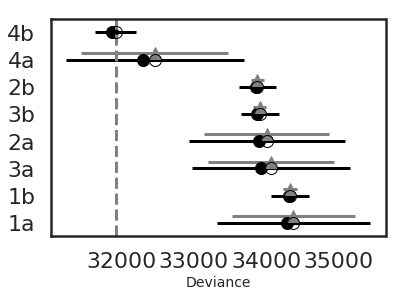

In [125]:
# model comparison
comp_waic = pm.compare(model_traces)
pm.compareplot(comp_waic)

In [127]:
comp_waic

WAIC  pWAIC    dWAIC weight       SE      dSE var_warn
4b  31922.6  25.65        0    0.1   285.16        0        1
4a  32461.1   80.6   538.53   0.89  1227.11  1012.91        1
2b  33877.4  10.98  1954.87   0.01   256.18    89.06        1
3b    33908  22.01  1985.39      0   259.77    90.11        1
2a  34003.2  54.46  2080.61      0  1076.48   866.06        1
3a    34063  66.17  2140.43      0  1085.38   875.24        1
1b  34327.1   4.48  2404.53   0.01   257.04   100.15        1
1a  34373.7  45.07  2451.09      0   1060.4   850.77        1

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb5907654e0>,
      dtype=object)

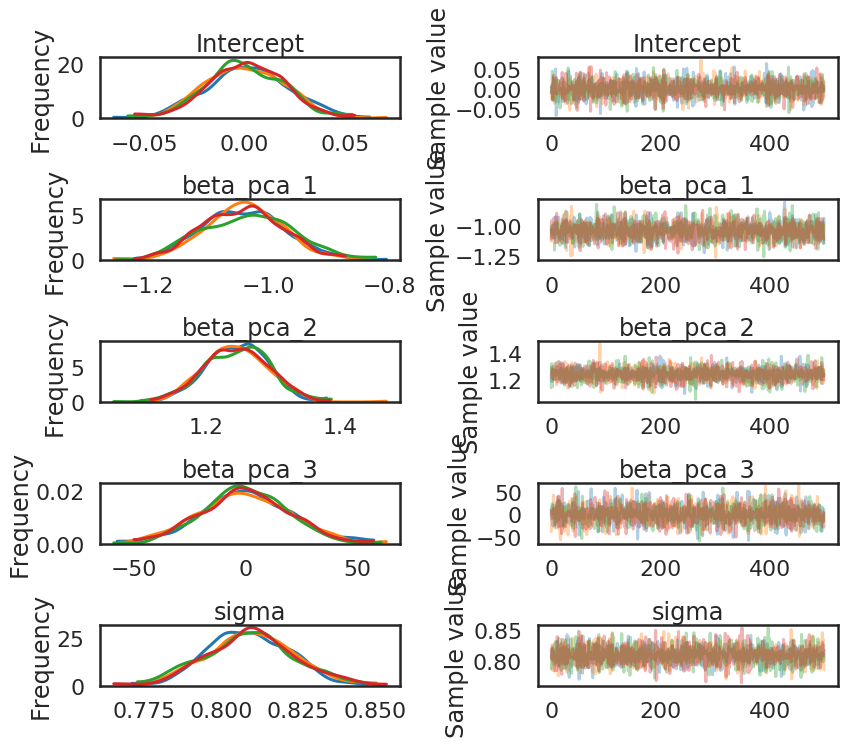

In [70]:
traceplot(list(model_traces.items())[6][1])

In [59]:
traceplot(model_traces[])

KeyError: 6

## Some simple clustering attempts

This was an earlier idea that came to my mind, but doesn't really seem to work

In [ ]:
mid_slice = df.y_mm.unique()[df.y_mm.unique().shape[0]/2]a

In [ ]:
df_to_plot = df.loc[df.y_mm==mid_slice]

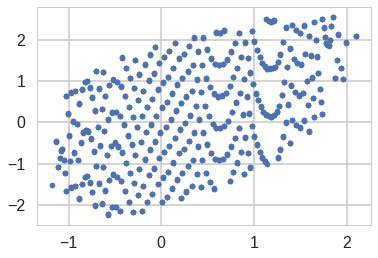

In [5]:
import pandas as pd
import matplotlib.cm as cm
%matplotlib inline
colors = cm.rainbow(df_to_plot.value.values)
colors = np.round(colors, 3)
idx = np.linspace(0, df_to_plot.shape[0]-1, 1000).astype(int)

plt.plot(df_to_plot.x_mm.values[idx], df_to_plot.z_mm.values[idx], '.') #list(map(tuple, colors[idx,:])))

In [6]:
df_singlesub = df_to_plot.copy()
df_singlesub = df_singlesub.loc[df_singlesub.subject_id==13095]

df_tmp = df_singlesub.loc[df_singlesub.index.repeat(df_singlesub.value.apply(lambda x: int(x) if pd.notnull(x) else 0))]

In [7]:
df_tmp.head()

fwhm  subject_id      x_mm     y_mm      z_mm stain     value
178961  0.15       13095 -1.180463 -0.33515 -1.232499  CALR  1.246892
178962  0.15       13095 -1.180463 -0.33515 -1.218407  CALR  1.452741
178963  0.15       13095 -1.180463 -0.33515 -1.133856  CALR  3.742728
178963  0.15       13095 -1.180463 -0.33515 -1.133856  CALR  3.742728
178963  0.15       13095 -1.180463 -0.33515 -1.133856  CALR  3.742728

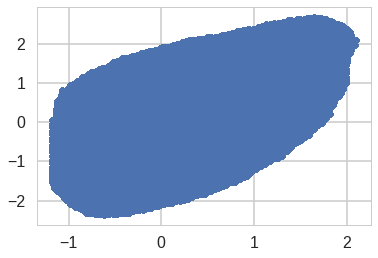

In [8]:
plt.plot(df_tmp.x_mm, df_tmp.z_mm, '.')

In [10]:
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

models = []
for n_clusters in [1,2,3,4,5,6]:
    gmm = mixture.GaussianMixture(n_components=n_clusters, covariance_type='full')
    gmm.fit(df_tmp[['x_mm', 'z_mm']])
    models.append(gmm)

# Z = -gmm_1cl.score_samples(XX)
# Z = Z.reshape(X.shape)

# CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
#                  levels=np.logspace(0, 3, 10))
# CB = plt.colorbar(CS, shrink=0.8, extend='both')
# plt.scatter(df_tmp[['x_mm']], df_tmp[['z_mm']], .01)
# plt.show()


In [11]:
x = np.linspace(-2., 2.)
y = np.linspace(-2., 2.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T

Zs = []
for model in models:
    Z = -model.score_samples(XX)
    Z = Z.reshape(X.shape)
    Zs.append(Z)

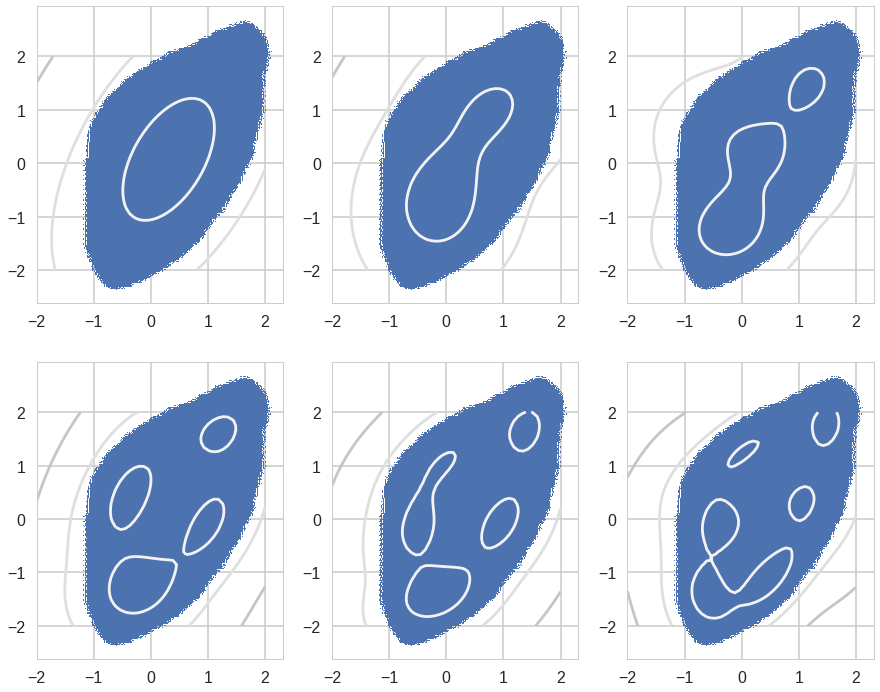

In [16]:
from matplotlib.colors import LogNorm

f, ax = plt.subplots(2,3)
axes = ax.ravel()
for i, Z in enumerate(Zs):
    CS = axes[i].contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                     levels=np.logspace(0, 3, 10))
#     CB = plt.colorbar(CS, shrink=0.8, extend='both')
    axes[i].scatter(df_tmp[['x_mm']], df_tmp[['z_mm']], .01)
#axes = axes.reshape((2,3))
f.set_size_inches(15, 12)
f.show()

In [ ]:
from matplotlib.colors import LogNorm

f, ax = plt.subplots(2,3)
axes = ax.ravel()
for i, Z in enumerate(Zs):
    CS = axes[i].contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                     levels=np.logspace(0, 3, 10))
#     CB = plt.colorbar(CS, shrink=0.8, extend='both')
    axes[i].scatter(df_tmp[['x_mm']], df_tmp[['z_mm']], .01)
#axes = axes.reshape((2,3))
f.set_size_inches(15, 12)
f.show()



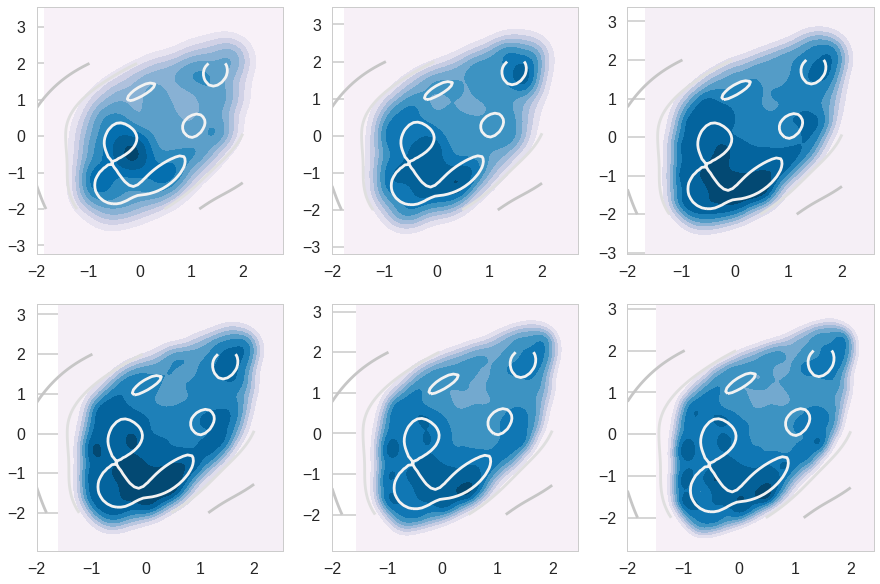

In [45]:
f, ax = plt.subplots(2,3)
axes = ax.ravel()
for i, n_vox in enumerate([1e3, 2e3, 5e3, 1e4, 2e4, 5e4]):
    idx = np.linspace(0, df_tmp.shape[0]-1, n_vox, dtype=int)
    sns.kdeplot(df_tmp[['x_mm', 'z_mm']].values[idx,:], shade = True, cmap = "PuBu", ax=axes[i])
    axes[i].contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                     levels=np.logspace(0, 3, 10))
    
f.set_size_inches(15, 10)

In [19]:
for model in models:
    print model.bic(df_tmp[['x_mm', 'z_mm']])

19531046.6042
19245205.1404
18905823.9689
18373725.1403
18267208.2478
18101425.4631


#### Everything below is tinkering around to see what's going on